# Classifying Political Rhetoric

## Table of Contents

1. Background
2. Data Understanding
3. Data Preparation
    - 3.a. Webscraping & Cleaning Presidential Debates
    - 3.b. Webscraping & Cleaning RNC/DNC Conventions
    - 3.c. Webscraping & Cleaning Inaugural Speeches
    - 3.d. NLP Preprocessing all 3 Datasets
        - 3.d.i. NLP Preprocessing the Presidential Debates
        - 3.d.ii. NLP Preprocessing the RNC/DNC Conventions
        - 3.d.i. NLP Preprocessing the Inaugural Speeches
    - 3.e. Combining all 3 Datasets
    - 3.f. EDA Visualization
    - 3.g. Additional Stopwords Removal
4. Modelling
    - 4.a. Multinomial Naive Bayes Model
        - 4.a.i. MNB Grid Searches
    - 4.b. Gaussian Bayes Model
        - 4.b.i. GB Grid Searches
    - 4.c. Random Forest Model
        - 4.c.i. RF Grid Searches
5. Final Results: MNB 
    - 5.a. Bigrams Only
    - 5.b. Unigrams and Bigrams
    - 5.c. Unigrams Only
6. Next Steps

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import re 

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## 1. Background

What words/phrases do politicians say most often?

Can we identify a politician’s party using their speech?

How has speech variance between parties changed over time?



## 2. Data Understanding

sources of data
how much data each of those sources have


## 3. Data Preparation

### 3.a. Webscraping & Cleaning Presidential Debates

Below we use Beautiful Soup to scrape text data from Presidential Debates 1960 on at www.debates.org. 

In [3]:
df = pd.DataFrame(columns=["date", "text", "link"])
debatelink = []

base_url = "https://www.debates.org"
page = requests.get(urljoin(base_url, "/voter-education/debate-transcripts/"))
soup = BeautifulSoup(page.content, 'html.parser')

links = soup.find_all("a")
for link in links:
    if "debate-transcript" in link.get("href") and "Media" not in link.get("href") and "vice" not in link.get("href"):
        debatelink.append(urljoin(base_url, link.get("href")))
        df.loc[len(df)] = [None, None, urljoin(base_url, link.get("href"))]

for link in df["link"]:
    try:
        page = requests.get(link)
        soup = BeautifulSoup(page.content, 'html.parser')
        text = soup.find_all("p")
        text = [t.get_text() for t in text]
        text = " ".join(text)
        df.loc[df["link"] == link, "text"] = text

        date_link = link.split("/")[5:6] 
        date_link = "-".join(date_link[0].split("-")[:3])
        df.loc[df["link"] == link, "date"] = date_link
    except requests.exceptions.RequestException as e:
        print(f"Error accessing {link}: {e}")

df

,date,text,link
0,,Unofficial transcripts of most presidential an...,https://www.debates.org/voter-education/debate...
1,october-22-2020,Presidential Debate at Belmont University in N...,https://www.debates.org/voter-education/debate...
2,september-29-2020,Presidential Debate at Case Western Reserve Un...,https://www.debates.org/voter-education/debate...
3,october-19-2016,Presidential Debate at the University of Nevad...,https://www.debates.org/voter-education/debate...
4,october-9-2016,Presidential Debate at Washington University i...,https://www.debates.org/voter-education/debate...
...,...,...,...
88,october-22-1976,"\nOctober 22, 1976\n The Third Carter-Ford Pre...",https://www.debates.org/voter-education/debate...
89,september-26-1960,"\nSeptember 26, 1960\n The First Kennedy-Nixon...",https://www.debates.org/voter-education/debate...
90,october-7-1960,"\nOctober 7, 1960\n The Second Kennedy-Nixon P...",https://www.debates.org/voter-education/debate...
91,october-13-1960,"\nOctober 13, 1960\n The Third Kennedy-Nixon P...",https://www.debates.org/voter-education/debate...


We want to strip the last 4 characters of each string in the 'date' column to get a column with just the year of each speech. Below we check every row to make sure there would be no inconsistencies with this method

In [4]:
df['date'][:50]

0                            
1             october-22-2020
2           september-29-2020
3             october-19-2016
4              october-9-2016
5              october-4-2016
6           september-26-2016
7             october-22-2012
8             october-16-2012
9              october-3-2012
10     2008-debate-transcript
11     2008-debate-transcript
12             october-7-2008
13            october-15-2008
14            october-13-2004
15             october-8-2004
16             october-5-2004
17          september-30-2004
18            october-17-2000
19            october-11-2000
20             october-5-2000
21             october-3-2000
22            october-16-1996
23             october-9-1996
24             october-6-1996
25            october-19-1992
26            october-15-1992
27            october-15-1992
28            october-13-1992
29            october-11-1992
30            october-11-1992
31            october-13-1988
32             october-5-1988
33        

In [5]:
df['date'][50:100]

50             october-4-2016
51             october-9-2016
52            october-19-2016
53             october-3-2012
54            october-16-2012
55            october-22-2012
56     2008-debate-transcript
57     2008-debate-transcript
58             october-7-2008
59            october-15-2008
60            october-13-2004
61             october-8-2004
62             october-5-2004
63          september-30-2004
64             october-3-2000
65             october-5-2000
66            october-11-2000
67            october-17-2000
68    2000-debate-transcripts
69             october-6-1996
70             october-9-1996
71            october-16-1996
72            october-11-1992
73            october-11-1992
74            october-13-1992
75            october-15-1992
76            october-15-1992
77            october-19-1992
78          september-25-1988
79             october-5-1988
80            october-13-1988
81             october-7-1984
82            october-11-1984
83        

From this exploration we can see that there are 6 rows that do not properly end in the year, so we cannot split the last four characters from them. Instead, we will .loc into those cells and enter their years by hand.

In [6]:
df['date'][10] = '2008'
df['date'][11] = '2008'
df['date'][46] = '2000'
df['date'][56] = '2008'
df['date'][57] = '2008'
df['date'][68] = '2000'

Now we'll take a look at one row in the 'text' column to see how it is structured. This will inform how we isolate the candidates' speech and remove all other speakers' speech.

In [7]:
df['text'][5]

'Vice Presidential Debate at Longwood University in Farmville, Virginia October 4, 2016 PARTICIPANTS: Senator Tim Kaine (D-VA) and Governor Mike Pence (R-IN) MODERATOR: Elaine Quijano (CBS News) QUIJANO: Good evening. From Longwood University in Farmville, Virginia, and welcome to the first, and only, vice presidential debate of 2016, sponsored by the Commission on Presidential Debates. I’m Elaine Quijano, anchor at CBSN, and correspondent for CBS News. It’s an honor to moderate this debate between Senator Tim Kaine and Governor Mike Pence. Both are longtime public servants who are also proud fathers of sons serving in the U.S. Marines. The campaigns have agreed to the rules of this 90-minute debate. There will be nine different segments covering domestic and foreign policy issues. Each segment will begin with a question to both candidates who will each have two minutes to answer. Then I’ll ask follow-up questions to facilitate a discussion between the candidates. By coin toss, it’s be

We can see that the candidates' speech is introduced by their name in all caps, followed by a colon. For example in the site above, Hillary Clinton's speech follows the following string "CLINTON:". 

Thus, in order to extract just the text that Hillary Clinton said, we need to extract just the text between all instances of the text "CLINTON:".

To accomplish that, we create a function that takes in text data and a name (in this case, 'CLINTON'). It loops through all of df['text'], using a regex pattern to search for all instances of 'CLINTON:'. It then extracts only the text starting at 'CLINTON:' and ending at the next instance of any all caps name followed by a colon. Then it adds that extracted text to a new row in a new dataframe called 'CLINTON'.

In [8]:
# Function to extract text between all-caps words followed by a colon
def extract_text_segments(text, name):
    pattern = f"{name}:\s*([\s\S]*?)(?=(?:[A-Z]+\s*:\s*|$))"
    matches = re.finditer(pattern, text)
    indices = [(match.start(), match.end()) for match in matches]

    extracted_texts = []
    for i in range(len(indices) - 1):
        start = indices[i][0]
        end = indices[i][1]
        extracted_text = text[start:end].strip()
        extracted_texts.append(extracted_text)

    return extracted_texts

extract_text_segments(df['text'][5], 'CLINTON')

[]

Below we define another function that creates a new dataframe containing only 3 columns: the year a speech was given, the name of the speaker we are interested in, and the text of what that speaker said in that speech.

We get the 'Year' column data by stripping the last four characters of the date strings in df['date'].

We get the 'Name' column data from a list of candidates initialized below.

We get the 'Text' column data by calling our previous function 'extract_text_segments' on each row in df['text']. To reiterate, that function will grab only the words said by candidates from the names list below. 

In [9]:
names = ['CLINTON', 'TRUMP', 'OBAMA', 'ROMNEY', 'MCCAIN', 'BUSH', 'KERRY', 'GORE', 'CLINTON', 'DOLE', 'DUKAKIS', 'REAGAN', 'MONDALE', 'CARTER', 'FORD', 'NIXON', 'KENNEDY', 'ANDERSON']

dict2 = {'Year': [], 'Name': [], 'Text': []}
df2 = pd.DataFrame(dict2)

def text_extractor(data):
    for name in names:
        for index, row in df.iterrows():
            if name in row['text']:
                extracted_text = extract_text_segments(row['text'], name)
                year = row['date'][-4:]
                df2.loc[len(df2.index)] = [year, name, extracted_text]
    return df2

result_df = text_extractor(df)
print(result_df)


     Year      Name                                               Text
0    2016   CLINTON  [CLINTON: Thank you very much, Chris. And than...
1    2016   CLINTON  [CLINTON: Well, thank you. Are you a teacher? ...
2    2016   CLINTON  [CLINTON: How are you, Donald? [applause], CLI...
3    1996   CLINTON  [CLINTON: I was going to applaud, too. Well, t...
4    1996   CLINTON  [CLINTON: Thank you, Jim. And thank you to the...
..    ...       ...                                                ...
163  1960   KENNEDY  [KENNEDY: In the first place I’ve never sugges...
164  1960   KENNEDY  [KENNEDY: Good evening, Mr. Shadel. MR., KENNE...
165  1960   KENNEDY  [KENNEDY: Good evening, Mr. Howe. MR., KENNEDY...
166  1980  ANDERSON  [ANDERSON: Miss Loomis, I think it’s very appr...
167  1980  ANDERSON  [ANDERSON: Miss Loomis, I think it’s very appr...

[168 rows x 3 columns]


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:950: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [10]:
result_df['Text'][1]

['CLINTON: Well, thank you. Are you a teacher? Yes, I think that that’s a very good question, because I’ve heard from lots of teachers and parents about some of their concerns about some of the things that are being said and done in this campaign. And I think it is very important for us to make clear to our children that our country really is great because we’re good. And we are going to respect one another, lift each other up. We are going to be looking for ways to celebrate our diversity, and we are going to try to reach out to every boy and girl, as well as every adult, to bring them in to working on behalf of our country. I have a very positive and optimistic view about what we can do together. That’s why the slogan of my campaign is “Stronger Together,” because I think if we work together, if we overcome the divisiveness that sometimes sets Americans against one another, and instead we make some big goals—and I’ve set forth some big goals, getting the economy to work for everyone,

In the resultant dataframe, the 'Text' column is a list of strings of each instance our candidate of interest spoke. We combine this list into one string below.

In [11]:
result_df['Text']= [" ".join(x) for x in result_df['Text']]

In [12]:
# Checking that the 'Text' is now one string
result_df['Text'][1]

'CLINTON: Well, thank you. Are you a teacher? Yes, I think that that’s a very good question, because I’ve heard from lots of teachers and parents about some of their concerns about some of the things that are being said and done in this campaign. And I think it is very important for us to make clear to our children that our country really is great because we’re good. And we are going to respect one another, lift each other up. We are going to be looking for ways to celebrate our diversity, and we are going to try to reach out to every boy and girl, as well as every adult, to bring them in to working on behalf of our country. I have a very positive and optimistic view about what we can do together. That’s why the slogan of my campaign is “Stronger Together,” because I think if we work together, if we overcome the divisiveness that sometimes sets Americans against one another, and instead we make some big goals—and I’ve set forth some big goals, getting the economy to work for everyone, 

In [13]:
type(result_df['Text'][1])

str

In [14]:
# Checking our text column
result_df['Text']

0      CLINTON: Thank you very much, Chris. And thank...
1      CLINTON: Well, thank you. Are you a teacher? Y...
2      CLINTON: How are you, Donald? [applause] CLINT...
3      CLINTON: I was going to applaud, too. Well, th...
4      CLINTON: Thank you, Jim. And thank you to the ...
                             ...                        
163    KENNEDY: In the first place I’ve never suggest...
164    KENNEDY: Good evening, Mr. Shadel. MR. KENNEDY...
165    KENNEDY: Good evening, Mr. Howe. MR. KENNEDY: ...
166    ANDERSON: Miss Loomis, I think it’s very appro...
167    ANDERSON: Miss Loomis, I think it’s very appro...
Name: Text, Length: 168, dtype: object

Above it seems like rows 166 and 167 are exact duplicates.

In [15]:
# Checking to see if rows 16 and 167 are identical
result_df.iloc[166] == result_df.iloc[167]

Year    True
Name    True
Text    True
dtype: bool

In [16]:
# Keeping only the first instance of any duplicate rows

result_df = result_df.drop_duplicates(keep='first')
result_df

,Year,Name,Text
0,2016,CLINTON,"CLINTON: Thank you very much, Chris. And thank..."
1,2016,CLINTON,"CLINTON: Well, thank you. Are you a teacher? Y..."
2,2016,CLINTON,"CLINTON: How are you, Donald? [applause] CLINT..."
3,1996,CLINTON,"CLINTON: I was going to applaud, too. Well, th..."
4,1996,CLINTON,"CLINTON: Thank you, Jim. And thank you to the ..."
...,...,...,...
158,1960,KENNEDY,"KENNEDY: Good evening, Mr. Howe. MR. KENNEDY: ..."
159,1960,KENNEDY,"KENNEDY: Good evening, Mr. Shadel. MR. KENNEDY..."
160,1960,KENNEDY,KENNEDY: In the first place I’ve never suggest...
161,1960,KENNEDY,"KENNEDY: Mr. Smith, Mr. Nixon. In the election..."


Now we output any rows that are nulls.

In [17]:
result_df[result_df['Text'].isna() == True]

,Year,Name,Text


In [18]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 0 to 166
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    74 non-null     object
 1   Name    74 non-null     object
 2   Text    74 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


There are now no nulls. Now that the Year and Text columns are ready for NLP preprocessing, we check on the Name column by running a value count.

In [19]:
result_df['Name'].value_counts()

Name
BUSH        14
CLINTON     10
OBAMA        6
GORE         5
TRUMP        5
CARTER       4
KENNEDY      4
NIXON        4
FORD         4
ROMNEY       3
MCCAIN       3
KERRY        3
DOLE         2
MONDALE      2
REAGAN       2
DUKAKIS      2
ANDERSON     1
Name: count, dtype: int64

We need to differentiate between Hillary and Bill Clinton and both George Bushes. So, we write a function to rename them according to the year.

In [20]:
# Function for re-naming both Clintons and Bushes
def rename(currentname, newname, year):
    mask = (result_df['Name'] == currentname) & (result_df['Year'] == year)
    result_df.loc[mask, 'Name'] = newname

In [21]:
# Calling the function to differentiate the Clintons and Bushes
rename("CLINTON", "H_CLINTON", "2016")
rename("CLINTON", "B_CLINTON", "1992")
rename("CLINTON", "B_CLINTON", "1996")
rename("BUSH", "BUSH_2", "2008")
rename("BUSH", "BUSH_2", "2004")
rename("BUSH", "BUSH_2", "2000")
rename("BUSH", "BUSH_1", "1988")
rename("BUSH", "BUSH_1", "1992")

In [22]:
# Checking to see that the function worked
result_df['Name'].value_counts()

Name
B_CLINTON    7
BUSH_1       7
OBAMA        6
BUSH_2       6
GORE         5
TRUMP        5
KENNEDY      4
NIXON        4
FORD         4
CARTER       4
H_CLINTON    3
KERRY        3
MCCAIN       3
ROMNEY       3
DOLE         2
DUKAKIS      2
REAGAN       2
MONDALE      2
BUSH         1
ANDERSON     1
Name: count, dtype: int64

There still seems to be one un-renamed instance of 'BUSH'.

In [23]:
# Looking at the un-renamed 'BUSH' rows
result_df[result_df['Name'] == 'BUSH']

,Year,Name,Text
67,1984,BUSH,"BUSH: Well, I don’t think there’s a great diff..."


We noticed an instance of 'BUSH' in our dataframe. It is for 1984, when George H.W. Bush ran as Reagan's V.P. Since we are interested in presidential candidates, we drop this rows below.

In [24]:
result_df = result_df[result_df['Name'] != "BUSH"]

In [25]:
# Checking to see that the 1984 BUSH row was dropped
result_df['Name'].value_counts()

Name
BUSH_1       7
B_CLINTON    7
OBAMA        6
BUSH_2       6
GORE         5
TRUMP        5
CARTER       4
KENNEDY      4
NIXON        4
FORD         4
H_CLINTON    3
KERRY        3
MCCAIN       3
ROMNEY       3
DUKAKIS      2
REAGAN       2
MONDALE      2
DOLE         2
ANDERSON     1
Name: count, dtype: int64

Now we need to create our target column. The loop below assigns a 0 to a 'Target' column if the person in that row is a Democrat, and assigns a 1 if they are a Republican. 

We also drop our one independent candidate, as we do not have enough data across our datasets to train or test our model to predict independents. 

In [26]:
dems = ['B_CLINTON', 'OBAMA', 'GORE', 'CARTER', 'KENNEDY', 'H_CLINTON', 'KERRY', 'DUKAKIS', 'MONDALE']
ind = ['ANDERSON']

result_df['Target'] = 1  # Default value for rows not matching dems or ind

for row in result_df['Name']:
    if row in dems:
        result_df.loc[result_df['Name'] == row, 'Target'] = 0
    else:
        result_df.loc[result_df['Name'] == row, 'Target'] = 1

result_df = result_df[result_df['Name'] != "ANDERSON"]
result_df

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_42305/332914409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Target'] = 1  # Default value for rows not matching dems or ind


,Year,Name,Text,Target
0,2016,H_CLINTON,"CLINTON: Thank you very much, Chris. And thank...",0
1,2016,H_CLINTON,"CLINTON: Well, thank you. Are you a teacher? Y...",0
2,2016,H_CLINTON,"CLINTON: How are you, Donald? [applause] CLINT...",0
3,1996,B_CLINTON,"CLINTON: I was going to applaud, too. Well, th...",0
4,1996,B_CLINTON,"CLINTON: Thank you, Jim. And thank you to the ...",0
...,...,...,...,...
153,1960,NIXON,"NIXON: Mr. Smith, Senator Kennedy. The things ...",1
158,1960,KENNEDY,"KENNEDY: Good evening, Mr. Howe. MR. KENNEDY: ...",0
159,1960,KENNEDY,"KENNEDY: Good evening, Mr. Shadel. MR. KENNEDY...",0
160,1960,KENNEDY,KENNEDY: In the first place I’ve never suggest...,0


In [27]:
# Checking that the independent candidate Anderson was dropped
result_df[result_df['Name'] == 'Anderson']

,Year,Name,Text,Target


In [28]:
# Checking that a Republican candidate was correctly classified as such
result_df[result_df['Name'] == "REAGAN"]

,Year,Name,Text,Target
126,1980,REAGAN,REAGAN: I don’t know what the differences migh...,1
127,1980,REAGAN,REAGAN: I believe that the only unpopular meas...,1


Here we check the class breakdown. It is important that both classes are about equal. We expect the exact same number of Republicans as Democrats

In [29]:
result_df['Target'].value_counts()

Target
0    36
1    36
Name: count, dtype: int64

Now we need to remove the name indicators from the transcript. The all caps names followed by a colon were previously used to identify candidates' speech in our custom function "extract_text_segments," but now their inclusion could incorrectly inflate the accuracy of our model's predictions. Obviously, text that says "CLINTON:" many times will be more easily categorized as Democratic. So, we loop through each row in our 'Text' column below and remove the candidates' names.

In [30]:
candidates = ['CLINTON:', 'OBAMA:', 'GORE:', 'CARTER:', 'KENNEDY:', 'KERRY:', 'DUKAKIS:', 'MONDALE:', 'DOLE:', 'ANDERSON:', 'BUSH:', "TRUMP:", "NIXON:", "MCCAIN:", 'FORD:', 'ROMNEY:', 'REAGAN:']

# Iterate through each row in the "Text" column
for index, row in result_df.iterrows():
    text = row['Text']
    
    # Iterate through each candidate in the list
    for candidate in candidates:
        # Check if candidate is in the text
        if candidate in text:
            # Replace candidate with an empty string
            text = text.replace(candidate, "")
    
    # Update the "Text" column with the modified text
    result_df.at[index, 'Text'] = text

result_df['Text'][1]

' Well, thank you. Are you a teacher? Yes, I think that that’s a very good question, because I’ve heard from lots of teachers and parents about some of their concerns about some of the things that are being said and done in this campaign. And I think it is very important for us to make clear to our children that our country really is great because we’re good. And we are going to respect one another, lift each other up. We are going to be looking for ways to celebrate our diversity, and we are going to try to reach out to every boy and girl, as well as every adult, to bring them in to working on behalf of our country. I have a very positive and optimistic view about what we can do together. That’s why the slogan of my campaign is “Stronger Together,” because I think if we work together, if we overcome the divisiveness that sometimes sets Americans against one another, and instead we make some big goals—and I’ve set forth some big goals, getting the economy to work for everyone, not just

Now we lower case all the text so that any difference in capitalization won't prevent the same words from being categorized together. I.e., we don't want "Court" to be considered different from "court."

In [31]:
# Lower casing the text and assigning it to a new column
result_df['text_lower'] = ["".join(item for item in lst).lower() for lst in result_df['Text']]

In [32]:
type(result_df['text_lower'][1])

str

### 3.b. Webscraping & Cleaning RNC/DNC Conventions

In [63]:


conventions = pd.DataFrame(columns=["date", "text", "link", "speaker", "convention"])
conventionlink = []
base_url = "https://www.presidency.ucsb.edu/documents/"
# URL of the page to scrape
url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/party-platforms-and-nominating-conventions-2"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the links on the page
links = soup.find_all("a")

# Extract the URLs from the links
urls = [link.get("href") for link in links]

for url in urls:
    if "nomination" in str(url):
        conventionlink.append(urljoin(base_url, url))

for link in conventionlink:
    try:
        page = requests.get(link)
        soup = BeautifulSoup(page.content, 'html.parser')
        links2 = soup.find_all("a")
        for link2 in links2:
            if "people" in str(link2):
                person = str(link2.get("href")).split("-")[-1]
        text = soup.find("div", class_="field-docs-content").find_all("p")
        text = [t.text for t in text]
        text = " ".join(text)
        date = soup.find_all("span", class_="date-display-single")
        date = [d.get_text() for d in date]
        date = date[0]
        title = soup.find("div", class_="field-ds-doc-title").find("h1").text
        if "Republican" in str(title):
            convention = "RNC"
        elif "Democratic" in str(title):
            convention = "DNC"
        else:
            convention = None
        conventions.loc[len(conventions)] = [date, text, link, person, convention]

    except requests.exceptions.RequestException as e:
        print(f"Error accessing {link}: {e}")

conventions.head()

,date,text,link,speaker,convention
0,"August 20, 2020","Good evening. Ella Baker, a giant of the civil...",https://www.presidency.ucsb.edu/documents/addr...,biden,DNC
1,"July 28, 2016","Thank you all very, very much! Thank you for t...",https://www.presidency.ucsb.edu/documents/addr...,clinton,DNC
2,"September 06, 2012",The First Lady. Thank you so much. Tonight I a...,https://www.presidency.ucsb.edu/documents/rema...,obama,DNC
3,"August 28, 2008",To Chairman Dean and my great friend Dick Durb...,https://www.presidency.ucsb.edu/documents/addr...,obama,DNC
4,"July 29, 2004",I'm John Kerry and I'm reporting for duty. We ...,https://www.presidency.ucsb.edu/documents/addr...,kerry,DNC


In [64]:
# convert date column to datetime
conventions["date"] = pd.to_datetime(conventions["date"])

# only keep years 
conventions["date"] = conventions["date"].dt.year

# only keep 1960 or later
conventions = conventions[conventions["date"] >= 1960]

# change 2000 speaker from "jr" to "gore"
conventions["speaker"] = conventions["speaker"].replace("jr", "gore")

conventions

,date,text,link,speaker,convention
0,2020,"Good evening. Ella Baker, a giant of the civil...",https://www.presidency.ucsb.edu/documents/addr...,biden,DNC
1,2016,"Thank you all very, very much! Thank you for t...",https://www.presidency.ucsb.edu/documents/addr...,clinton,DNC
2,2012,The First Lady. Thank you so much. Tonight I a...,https://www.presidency.ucsb.edu/documents/rema...,obama,DNC
3,2008,To Chairman Dean and my great friend Dick Durb...,https://www.presidency.ucsb.edu/documents/addr...,obama,DNC
4,2004,I'm John Kerry and I'm reporting for duty. We ...,https://www.presidency.ucsb.edu/documents/addr...,kerry,DNC
5,2000,Thank you very much. Thank you. [applause] Tha...,https://www.presidency.ucsb.edu/documents/addr...,gore,DNC
6,1996,The President. Thank you. Thank you very much....,https://www.presidency.ucsb.edu/documents/rema...,clinton,DNC
7,1992,"Governor Richards, Chairman Brown, Mayor Dinki...",https://www.presidency.ucsb.edu/documents/addr...,clinton,DNC
8,1988,Mr. Chairman. A few months ago when Olympia Du...,https://www.presidency.ucsb.edu/documents/addr...,dukakis,DNC
9,1984,"My fellow Democrats, my fellow Americans: I ac...",https://www.presidency.ucsb.edu/documents/addr...,mondale,DNC


In [65]:
#renaming df
conventions_df = conventions
#renaming columns to match other df
conventions_df = conventions_df.rename(columns={'date': 'Year', 'text': 'Text', 'speaker': 'Name'})
#making the names all capitals
conventions_df['Name'] = conventions_df['Name'].str.upper()

Renaming Clintons and Bushes in the conventions_df

In [66]:
mask = (conventions_df['Name'] == "CLINTON") & (conventions_df['Year'] < 2010)
conventions_df.loc[mask, 'Name'] = "B_CLINTON"
mask = (conventions_df['Name'] == "CLINTON") & (conventions_df['Year'] > 2010)
conventions_df.loc[mask, 'Name'] = "H_CLINTON"
mask = (conventions_df['Name'] == "BUSH") & (conventions_df['Year'] > 1996)
conventions_df.loc[mask, 'Name'] = "BUSH_2"
mask = (conventions_df['Name'] == "BUSH") & (conventions_df['Year'] < 1996)
conventions_df.loc[mask, 'Name'] = "BUSH_1"

In [67]:
# Checking that the Clintons and Bushes were renamed properly
conventions_df['Name'].value_counts()

Name
NIXON        3
TRUMP        2
OBAMA        2
B_CLINTON    2
REAGAN       2
BUSH_1       2
CARTER       2
BUSH_2       2
BIDEN        1
FORD         1
DOLE         1
MCCAIN       1
ROMNEY       1
JOHNSON      1
KENNEDY      1
H_CLINTON    1
HUMPHREY     1
MCGOVERN     1
MONDALE      1
DUKAKIS      1
GORE         1
KERRY        1
GOLDWATER    1
Name: count, dtype: int64

### 3.c. Webscraping & Cleaning Inaugural Speeches

Creating a dataframe for scraped text from inaugural speeches website. 

In [69]:
inaugural_df = pd.DataFrame(columns=["date", "name", "text", "link"])
inauglinks = []
base_url = "https://www.presidency.ucsb.edu/documents/"
# URL of the page to scrape
url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/inaugural-addresses"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the links on the page
links = soup.find_all("a")


for link in links:
    if "inaugural-address-" in str(link) or "the-presidents-inaugural-address" in str(link) or "https://www.presidency.ucsb.edu/documents/inaugural-address" in str(link):
        url = link.get("href")
        date = link.text
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        text = soup.find("div", class_="field-docs-content").find_all("p")
        text = [t.text for t in text]
        text = " ".join(text)
        links2 = soup.find_all("a")
        for link in links2:
            if "people" in str(link):
                person = str(link.get("href")).split("-")[-1]
        inaugural_df.loc[len(inaugural_df.index)] = [date, person, text, url]


inaugural_df = inaugural_df.drop(index=range(41))
inaugural_df.head()

,date,name,text,link
41,"January 20, 1961",kennedy,"Vice President Johnson, Mr. Speaker, Mr. Chief...",https://www.presidency.ucsb.edu/documents/inau...
42,"January 20, 1965",johnson,My fellow countrymen: On this occasion the oat...,https://www.presidency.ucsb.edu/documents/the-...
43,"January 20, 1969",nixon,"Senator Dirksen, Mr. Chief Justice, Mr. Vice p...",https://www.presidency.ucsb.edu/documents/inau...
44,"January 20, 1977",carter,"For myself and for our Nation, I want to thank...",https://www.presidency.ucsb.edu/documents/inau...
45,"January 20, 1981",reagan,"Senator Hatfield, Mr. Chief Justice, Mr. Presi...",https://www.presidency.ucsb.edu/documents/inau...


Cleaning the text column and date column for analysis.

In [70]:
inaugural_df['text_lower'] = ["".join(item for item in lst).lower() for lst in inaugural_df['text']]
inaugural_df['date'] = [year[-4:] for year in inaugural_df['date']]

In [71]:
inaugural_df.reset_index(drop=True, inplace=True)

Creating the binary target column for the inaugural speeches dataset:

In [72]:
#inaugural_df.drop(columns='Unnamed: 0', inplace=True)
inaugural_df.rename(columns = {'date':'Year', 'name':'Name','text':'Text', 'tokens':'list_tokens'}, inplace = True)

dems = ['kennedy', 'johnson', 'carter', 'clinton', 'obama', 'biden']

inaugural_df['Target'] = 1  # Default value for rows not matching dems or ind

for row in inaugural_df['Name']:
    if row in dems:
        inaugural_df.loc[inaugural_df['Name'] == row, 'Target'] = 0
    else:
        inaugural_df.loc[inaugural_df['Name'] == row, 'Target'] = 1
        
inaugural_df['Name'] = [name.upper() for name in inaugural_df['Name']]

inaugural_df.head()

,Year,Name,Text,link,text_lower,Target
0,1961,KENNEDY,"Vice President Johnson, Mr. Speaker, Mr. Chief...",https://www.presidency.ucsb.edu/documents/inau...,"vice president johnson, mr. speaker, mr. chief...",0
1,1965,JOHNSON,My fellow countrymen: On this occasion the oat...,https://www.presidency.ucsb.edu/documents/the-...,my fellow countrymen: on this occasion the oat...,0
2,1969,NIXON,"Senator Dirksen, Mr. Chief Justice, Mr. Vice p...",https://www.presidency.ucsb.edu/documents/inau...,"senator dirksen, mr. chief justice, mr. vice p...",1
3,1977,CARTER,"For myself and for our Nation, I want to thank...",https://www.presidency.ucsb.edu/documents/inau...,"for myself and for our nation, i want to thank...",0
4,1981,REAGAN,"Senator Hatfield, Mr. Chief Justice, Mr. Presi...",https://www.presidency.ucsb.edu/documents/inau...,"senator hatfield, mr. chief justice, mr. presi...",1


In [73]:
inaugural_df['Name'].value_counts()

Name
BUSH       3
REAGAN     2
CLINTON    2
OBAMA      2
KENNEDY    1
JOHNSON    1
NIXON      1
CARTER     1
TRUMP      1
BIDEN      1
Name: count, dtype: int64

Renaming the Clintons and Bushes

In [75]:
inaugural_df['Year'] = inaugural_df['Year'].astype(int)
inaugural_df['Name'] = inaugural_df['Name'].replace(to_replace={'CLINTON':'B_CLINTON'})
mask = (inaugural_df['Name'] == "BUSH") & (inaugural_df['Year'] > 1990)
inaugural_df.loc[mask, 'Name'] = "BUSH_2"
mask = (inaugural_df['Name'] == "BUSH") & (inaugural_df['Year'] < 1990)
inaugural_df.loc[mask, 'Name'] = "BUSH_1"

In [76]:
# Checking that the Clintons and Bushes were renamed properly
inaugural_df['Name'].value_counts()

Name
REAGAN       2
B_CLINTON    2
BUSH_2       2
OBAMA        2
KENNEDY      1
JOHNSON      1
NIXON        1
CARTER       1
BUSH_1       1
TRUMP        1
BIDEN        1
Name: count, dtype: int64

### 3.d. NLP Preprocessing all 3 Datasets

Natural Language Processing invovles inputs of a certain type: namely, "tokenized" text. Ideally, a string of lower-case, individual, normalized, semantic words. 

Below we initialize a tokenizer, a stopwords list, and a lemmatizer that we use in a custom function. 

The tokenizer will use a regex pattern to turn all words that are at least 3 letters long into a "token."

The stopwords list will be used to remove words like "is" the "the." These are filler words that have no semantic meaning but are still the majority of most speech. They are not useful for prediction and they dramatically increase the input that a model must process. Therefore, our function iterates through the tokenized text and removes them.

Finally our lemmatizer will get to the meaningful "base" or "lemma" of a word. So it will take "change," "changes," "changed," and "changing" and identify them all as the token "change" instead of 4 separate words. This is essentially the "normalization" of text.

In [77]:
tokenizer = RegexpTokenizer(r"(?u)\w{3,}") # This pattern finds words that are at least 3 letters long
stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def preprocessing(text, tokenizer, stopwords, lemmatizer):
    # Make everything in the df["Text"] column into a lower-case string
    #text = ["".join(item for item in lst).lower() for lst in text]

    # Tokenize
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

#### 3.d.i. NLP Preprocessing the Presidential Debates

In [78]:
# Apply the preprocessing function to the 'Text' column
result_df['list_tokens'] = result_df['text_lower'].apply(lambda x: preprocessing(x, tokenizer, stopwords, lemmatizer))
result_df

,Year,Name,Text,Target,text_lower,list_tokens
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn..."
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest..."
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0,"how are you, donald? [applause] well, thank ...","[donald, applause, well, thank, lester, thanks..."
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, jim, thanks, peo..."
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0,"thank you, jim. and thank you to the people o...","[thank, jim, thank, people, hartford, host, wa..."
...,...,...,...,...,...,...
153,1960,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,"mr. smith, senator kennedy. the things that s...","[smith, senator, kennedy, thing, senator, kenn..."
158,1960,KENNEDY,"Good evening, Mr. Howe. MR. Mr. Howe, Mr. Vi...",0,"good evening, mr. howe. mr. mr. howe, mr. vi...","[good, evening, howe, howe, vice, president, f..."
159,1960,KENNEDY,"Good evening, Mr. Shadel. MR. Mr. McGee, we ...",0,"good evening, mr. shadel. mr. mr. mcgee, we ...","[good, evening, shadel, mcgee, contractual, ri..."
160,1960,KENNEDY,In the first place I’ve never suggested that ...,0,in the first place i’ve never suggested that ...,"[first, place, never, suggested, cuba, lost, e..."


Our custom function returns the tokenized text as a list. Our model needs the tokens as one string.

In [79]:
type(result_df['list_tokens'][0])

list

In [80]:
# making the tokens list of strings into one big string 
result_df['string_tokens'] = result_df['list_tokens'].apply(lambda x: ' '.join(x))
result_df['string_tokens'][0]

'thank much chris thanks unlv hosting know think talk supreme court really raise central issue election namely kind country going kind opportunity provide citizen kind right american feel strongly supreme court need stand side american people side powerful corporation wealthy mean need supreme court stand behalf woman right behalf right lgbt community stand say citizen united decision undermined election system country way permit dark unaccountable money come electoral system major disagreement opponent issue others supreme court feel point country history important reverse marriage equality reverse roe wade stand citizen united stand right people workplace stand basically say supreme court represent see court kind people would looking nominate court would great tradition standing powerful standing behalf right american look forward opportunity would hope senate would job confirm nominee president obama sent way constitution fundamentally operate president nominates senate advises cons

In [82]:
# Saving df as a csv
result_df.to_csv('data/result_df.csv')

#### 3.d.ii. NLP Preprocessing the RNC/DNC Conventions

In [96]:
tokenized_df = conventions['text'].apply((lambda x: preprocessing(x, tokenizer, stopwords, lemmatizer)))
conventions_df['tokens'] = tokenized_df
conventions_df['tokens'] = conventions_df['tokens'].apply(lambda x: [token.lower() for token in x])
conventions_df.head()

,Year,Text,link,Name,convention,tokens
0,2020,"Good evening. Ella Baker, a giant of the civil...",https://www.presidency.ucsb.edu/documents/addr...,BIDEN,DNC,"[good, evening, ella, baker, giant, civil, rig..."
1,2016,"Thank you all very, very much! Thank you for t...",https://www.presidency.ucsb.edu/documents/addr...,H_CLINTON,DNC,"[thank, much, thank, amazing, welcome, thank, ..."
2,2012,The First Lady. Thank you so much. Tonight I a...,https://www.presidency.ucsb.edu/documents/rema...,OBAMA,DNC,"[the, first, lady, thank, much, tonight, thril..."
3,2008,To Chairman Dean and my great friend Dick Durb...,https://www.presidency.ucsb.edu/documents/addr...,OBAMA,DNC,"[chairman, dean, great, friend, dick, durbin, ..."
4,2004,I'm John Kerry and I'm reporting for duty. We ...,https://www.presidency.ucsb.edu/documents/addr...,KERRY,DNC,"[john, kerry, reporting, duty, tonight, love, ..."


In [102]:
# saving to csv
conventions_df.to_csv('data/conventions_df.csv')

#### 3.d.iii. NLP Preprocessing the Inaugural Speeches

Run preprocessing on inaugural speeches df. Using preprocessing function from earlier.

In [103]:
inaugural_df['tokens'] = inaugural_df['text_lower'].apply(lambda x: preprocessing(x, tokenizer, stopwords, lemmatizer))

In [104]:
inaugural_df['tokens'][0][0:10]

['vice',
 'president',
 'johnson',
 'speaker',
 'chief',
 'justice',
 'president',
 'eisenhower',
 'vice',
 'president']

### 3.e. Combining all 3 Datasets

We need to make sure all three datasets' columns of interest have the same names so that we can join them together properly

In [105]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 0 to 161
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           72 non-null     object
 1   Name           72 non-null     object
 2   Text           72 non-null     object
 3   Target         72 non-null     int64 
 4   text_lower     72 non-null     object
 5   list_tokens    72 non-null     object
 6   string_tokens  72 non-null     object
dtypes: int64(1), object(6)
memory usage: 6.6+ KB


In [106]:
result_df.rename(columns = {'tokens':'string_tokens'}, inplace = True)
result_df.head()

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0,"how are you, donald? [applause] well, thank ...","[donald, applause, well, thank, lester, thanks...",donald applause well thank lester thanks hofst...
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, jim, thanks, peo...",going applaud well thank jim thanks people san...
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0,"thank you, jim. and thank you to the people o...","[thank, jim, thank, people, hartford, host, wa...",thank jim thank people hartford host want begi...


In [107]:
conventions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 0 to 44
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        32 non-null     int32 
 1   Text        32 non-null     object
 2   link        32 non-null     object
 3   Name        32 non-null     object
 4   convention  31 non-null     object
 5   tokens      32 non-null     object
dtypes: int32(1), object(5)
memory usage: 1.6+ KB


In [108]:
conventions_df = pd.read_csv('data/conventions.csv')
conventions_df.rename(columns = {'date':'Year', 'speaker':'Name','text':'Text', 'convention':'Target','tokens':'list_tokens'}, inplace = True)
conventions_df['Target'] = conventions_df['Target'].replace(to_replace={'DNC':0, 'RNC':1})
conventions_df.loc[(conventions_df['Name'] == 'johnson') & (conventions_df['Year'] == 1964), 'Target'] = 0
conventions_df['Name'] = [name.upper() for name in conventions_df['Name']]
# conventions_df.iloc[14]['Target'] = 0
# conventions_df[conventions_df['Target'].isna()]
conventions_df.head()

,Year,Text,link,Name,Target,list_tokens,string_tokens
0,2020,"Good evening. Ella Baker, a giant of the civil...",https://www.presidency.ucsb.edu/documents/addr...,BIDEN,0.0,"['good', 'evening', 'ella', 'baker', 'giant', ...",good evening ella baker giant civil right move...
1,2016,"Thank you all very, very much! Thank you for t...",https://www.presidency.ucsb.edu/documents/addr...,CLINTON,0.0,"['thank', 'much', 'thank', 'amazing', 'welcome...",thank much thank amazing welcome thank great c...
2,2012,The First Lady. Thank you so much. Tonight I a...,https://www.presidency.ucsb.edu/documents/rema...,OBAMA,0.0,"['first', 'lady', 'thank', 'much', 'tonight', ...",first lady thank much tonight thrilled honored...
3,2008,To Chairman Dean and my great friend Dick Durb...,https://www.presidency.ucsb.edu/documents/addr...,OBAMA,0.0,"['chairman', 'dean', 'great', 'friend', 'dick'...",chairman dean great friend dick durbin fellow ...
4,2004,I'm John Kerry and I'm reporting for duty. We ...,https://www.presidency.ucsb.edu/documents/addr...,KERRY,0.0,"['john', 'kerry', 'reporting', 'duty', 'tonigh...",john kerry reporting duty tonight love country...


In [115]:

inaugural_df.rename(columns={'tokens':'list_tokens'}, inplace=True)
inaugural_df["string_tokens"] = inaugural_df["list_tokens"].apply(lambda x: " ".join(x))
inaugural_df.head()

,Year,Name,Text,link,text_lower,Target,list_tokens,string_tokens
0,1961,KENNEDY,"Vice President Johnson, Mr. Speaker, Mr. Chief...",https://www.presidency.ucsb.edu/documents/inau...,"vice president johnson, mr. speaker, mr. chief...",0,"[vice, president, johnson, speaker, chief, jus...",vice president johnson speaker chief justice p...
1,1965,JOHNSON,My fellow countrymen: On this occasion the oat...,https://www.presidency.ucsb.edu/documents/the-...,my fellow countrymen: on this occasion the oat...,0,"[fellow, countryman, occasion, oath, taken, go...",fellow countryman occasion oath taken god mine...
2,1969,NIXON,"Senator Dirksen, Mr. Chief Justice, Mr. Vice p...",https://www.presidency.ucsb.edu/documents/inau...,"senator dirksen, mr. chief justice, mr. vice p...",1,"[senator, dirksen, chief, justice, vice, presi...",senator dirksen chief justice vice president p...
3,1977,CARTER,"For myself and for our Nation, I want to thank...",https://www.presidency.ucsb.edu/documents/inau...,"for myself and for our nation, i want to thank...",0,"[nation, want, thank, predecessor, done, heal,...",nation want thank predecessor done heal land o...
4,1981,REAGAN,"Senator Hatfield, Mr. Chief Justice, Mr. Presi...",https://www.presidency.ucsb.edu/documents/inau...,"senator hatfield, mr. chief justice, mr. presi...",1,"[senator, hatfield, chief, justice, president,...",senator hatfield chief justice president vice ...


Now that the columns have consistent names, we can concatenate them all by those shared columns

In [116]:
final_df = pd.concat([result_df, conventions_df, inaugural_df], axis=0)
final_df

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,link
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0.0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,NaN
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0.0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,NaN
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0.0,"how are you, donald? [applause] well, thank ...","[donald, applause, well, thank, lester, thanks...",donald applause well thank lester thanks hofst...,NaN
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0.0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, jim, thanks, peo...",going applaud well thank jim thanks people san...,NaN
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0.0,"thank you, jim. and thank you to the people o...","[thank, jim, thank, people, hartford, host, wa...",thank jim thank people hartford host want begi...,NaN
...,...,...,...,...,...,...,...,...
10,2005,BUSH_2,"Vice President Cheney, Mr. Chief Justice, Pres...",1.0,"vice president cheney, mr. chief justice, pres...","[vice, president, cheney, chief, justice, pres...",vice president cheney chief justice president ...,https://www.presidency.ucsb.edu/documents/inau...
11,2009,OBAMA,"My fellow citizens, I stand here today humbled...",0.0,"my fellow citizens, i stand here today humbled...","[fellow, citizen, stand, today, humbled, task,...",fellow citizen stand today humbled task gratef...,https://www.presidency.ucsb.edu/documents/inau...
12,2013,OBAMA,Thank you. Thank you so much. Vice President B...,0.0,thank you. thank you so much. vice president b...,"[thank, thank, much, vice, president, biden, c...",thank thank much vice president biden chief ju...,https://www.presidency.ucsb.edu/documents/inau...
13,2017,TRUMP,"Chief Justice Roberts, President Carter, Presi...",1.0,"chief justice roberts, president carter, presi...","[chief, justice, robert, president, carter, pr...",chief justice robert president carter presiden...,https://www.presidency.ucsb.edu/documents/inau...


In [117]:
final_df.isna().sum()

Year              0
Name              0
Text              0
Target            0
text_lower       32
list_tokens       0
string_tokens     0
link             72
dtype: int64

It is okay that we have nulls in the 'text_lower' and 'link' columns, as only our presidential debates (result_df) dataset had the former, and only our conventions and inaugural speeches datasets had the latter. They are not necessary for our analysis.

However, we do want every row to have the tokens in the form of a string: i.e., we want no nulls in the 'string_tokens' column. So, we simply replace that column with the 'list_tokens' column typecasted into a string.

In [118]:
import ast

# Function to convert string to list
def convert_string_to_list(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return string  # returns the original string in case of an error

# Apply this function to the desired column
final_df['list_tokens'] = final_df['list_tokens'].apply(convert_string_to_list)

In [119]:
final_df['string_tokens']= [" ".join(x) for x in final_df['list_tokens']]

In [120]:
final_df.isna().sum()

Year              0
Name              0
Text              0
Target            0
text_lower       32
list_tokens       0
string_tokens     0
link             72
dtype: int64

We will not save this final dataset until we inspect the most common words and confirm that our stopwords list is as complete as possible. 

### 3.f. EDA Visualization

Now that we have the data prepared for vectorization, we created functions for visualizations to perform EDA.

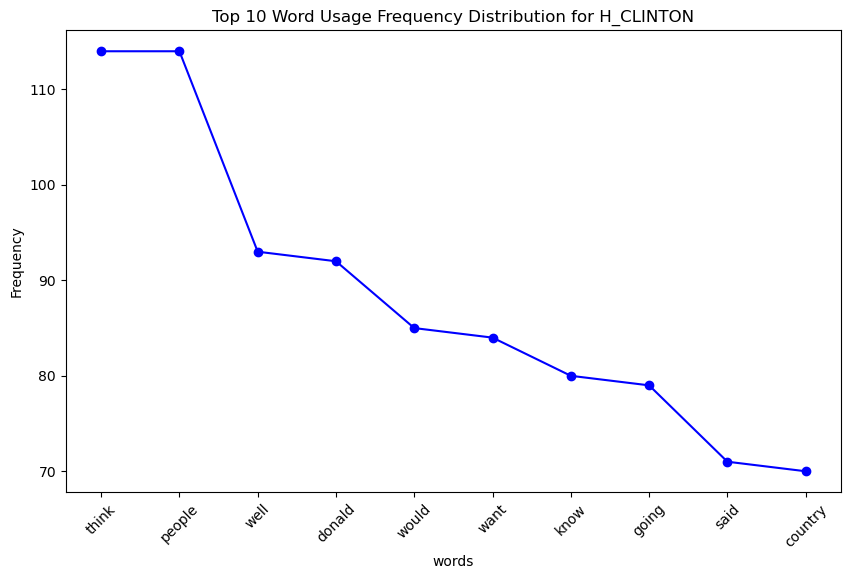

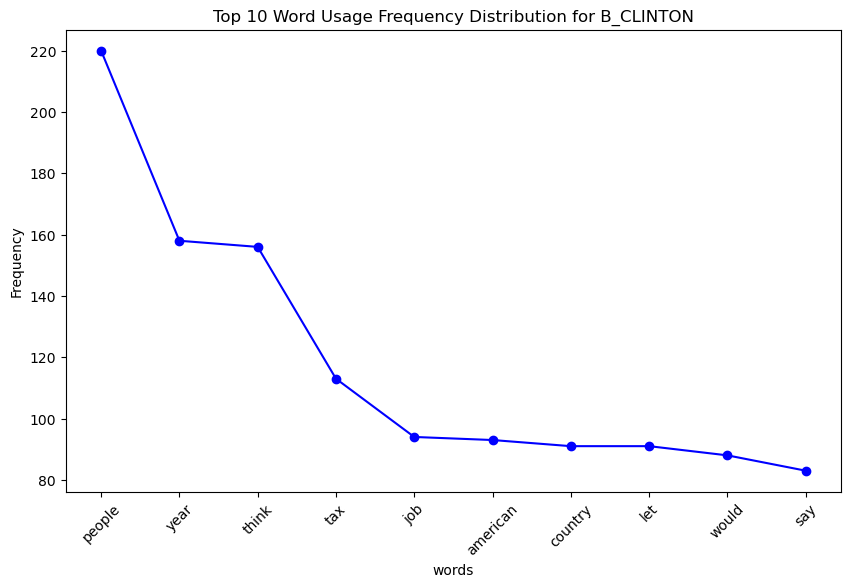

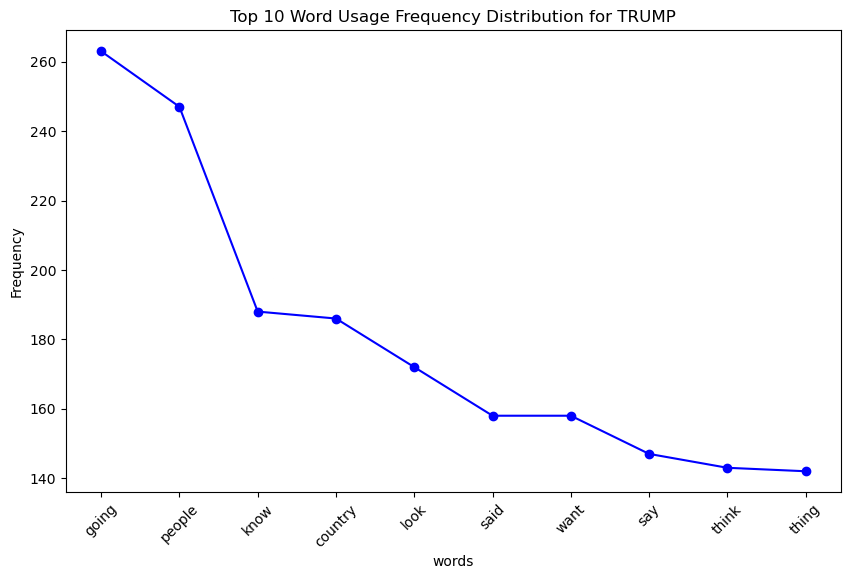

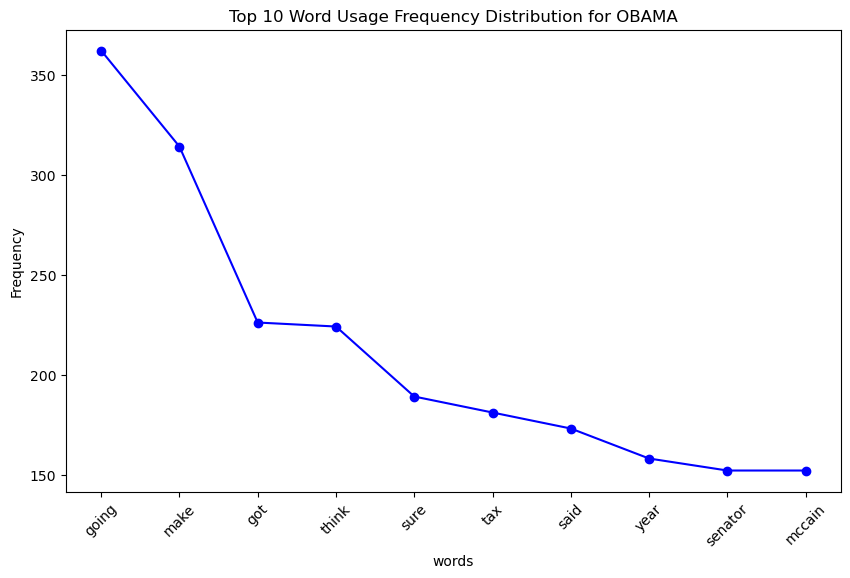

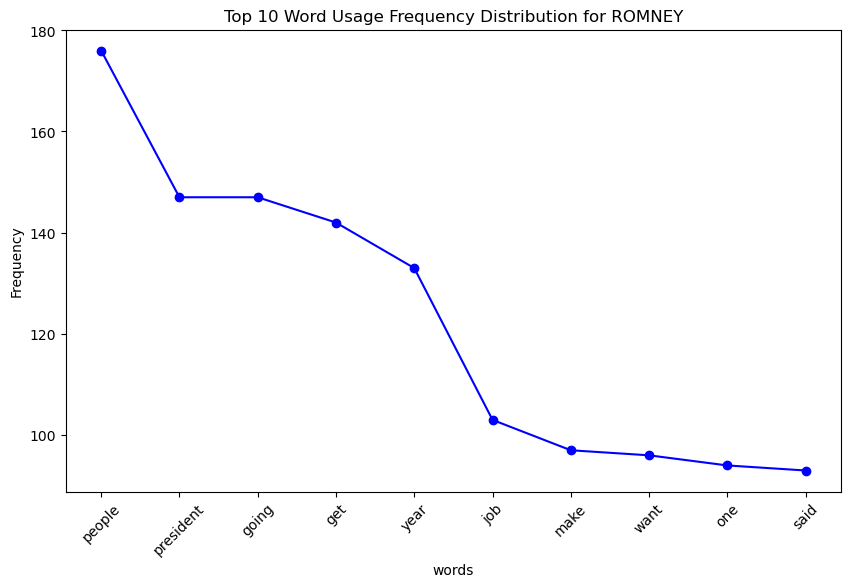

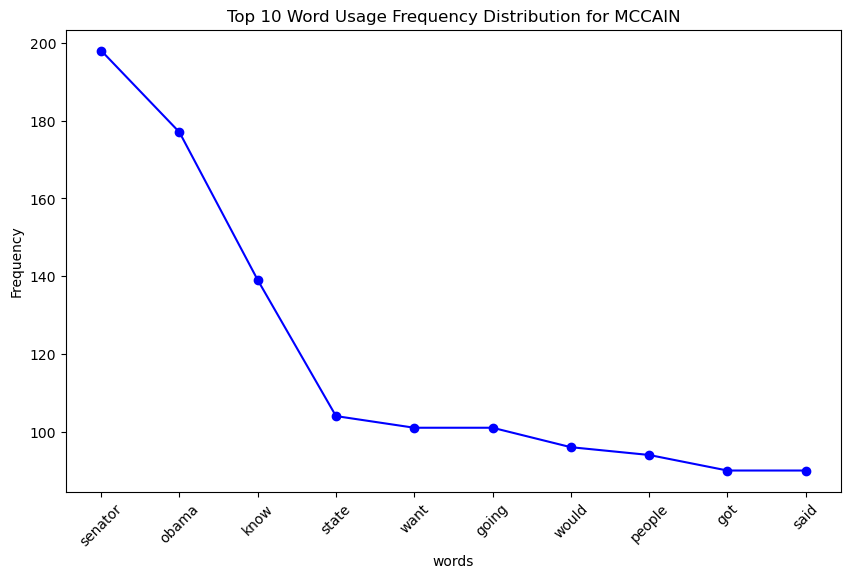

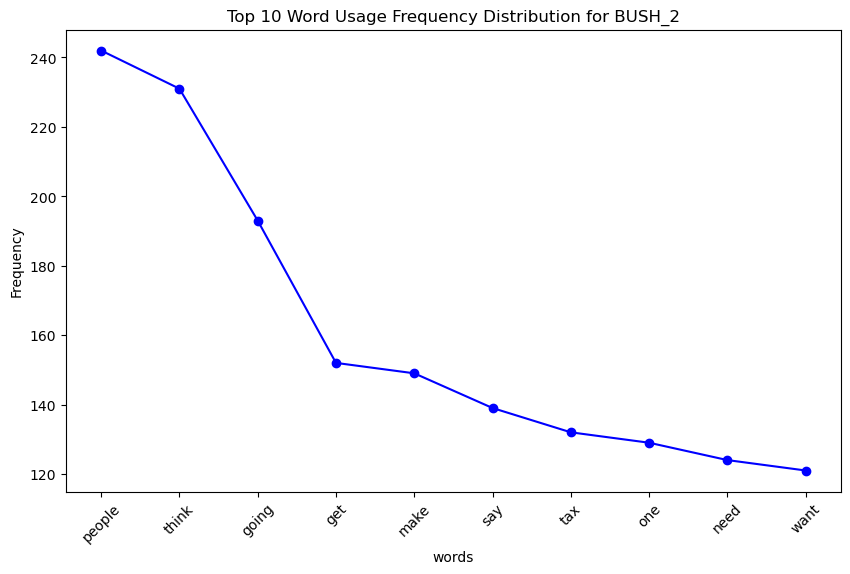

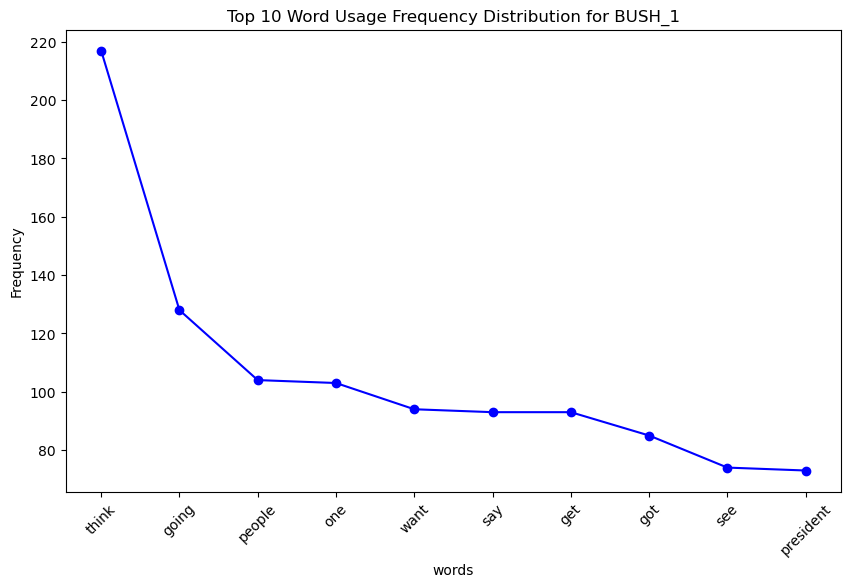

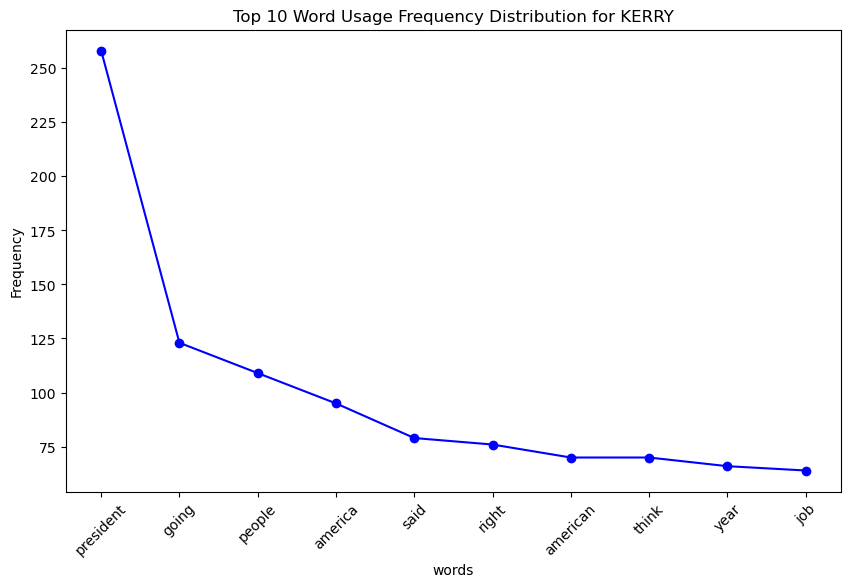

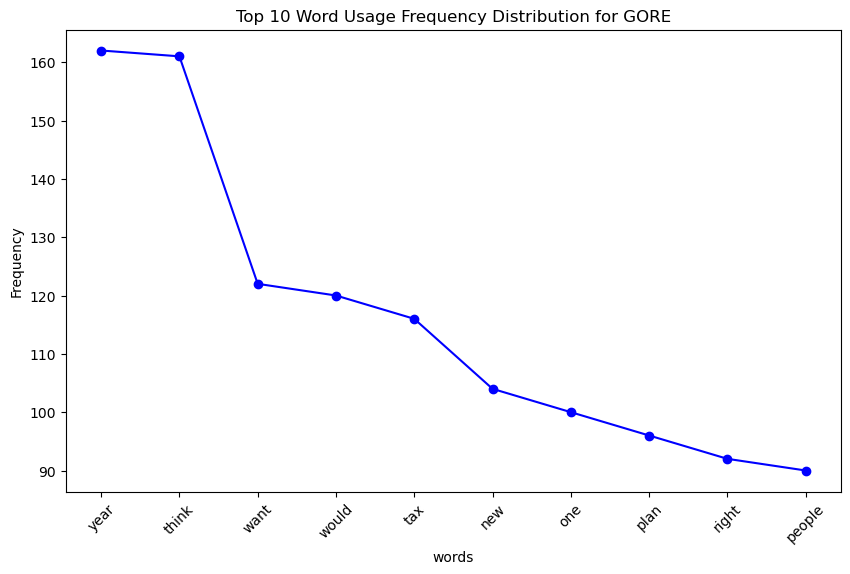

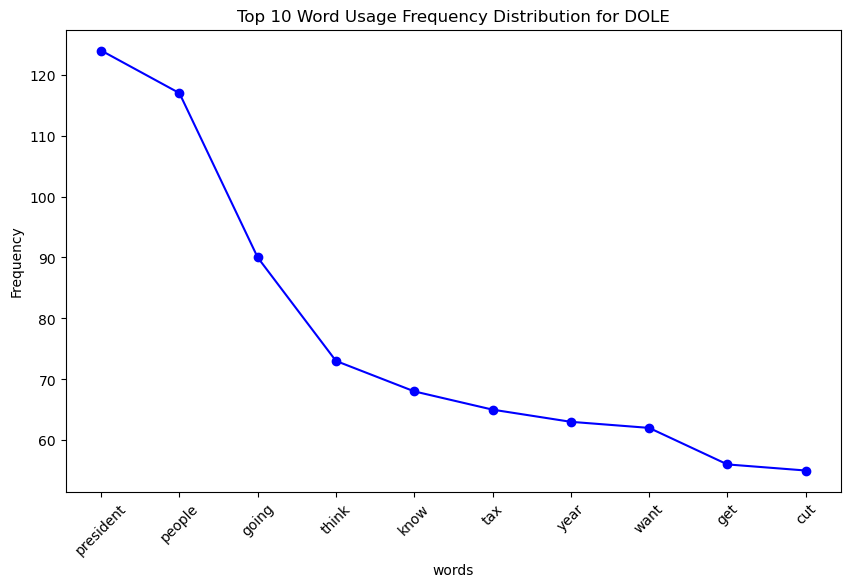

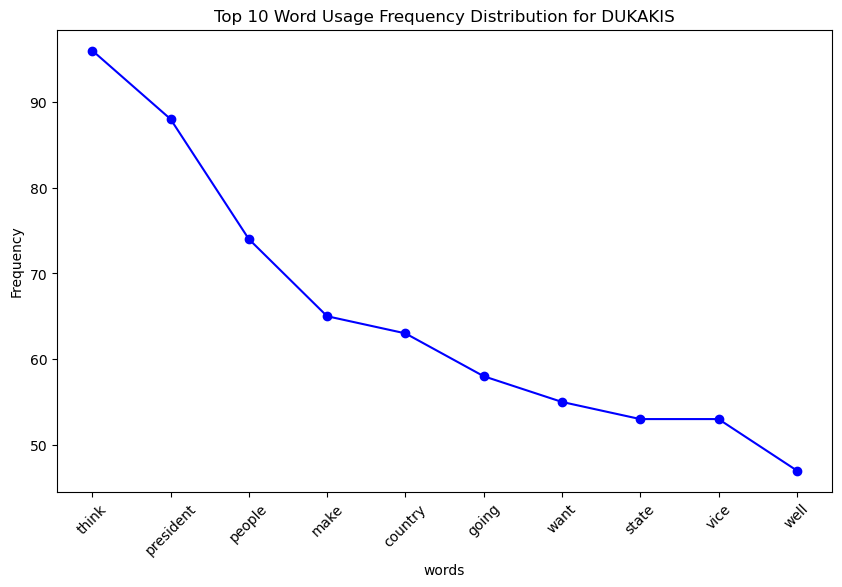

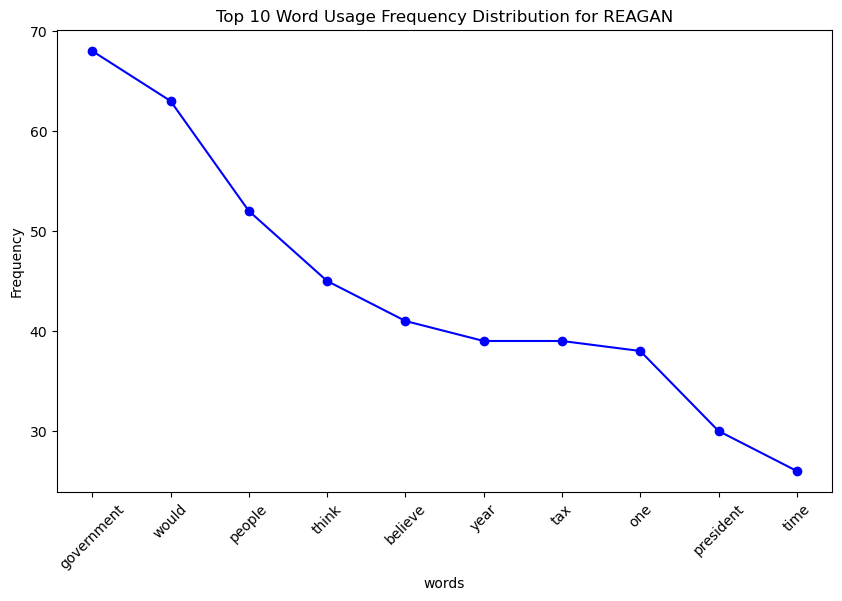

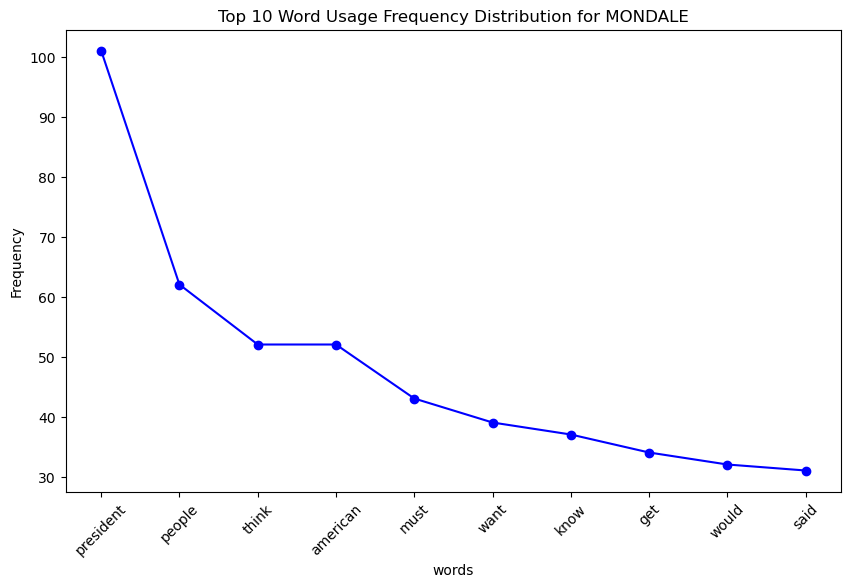

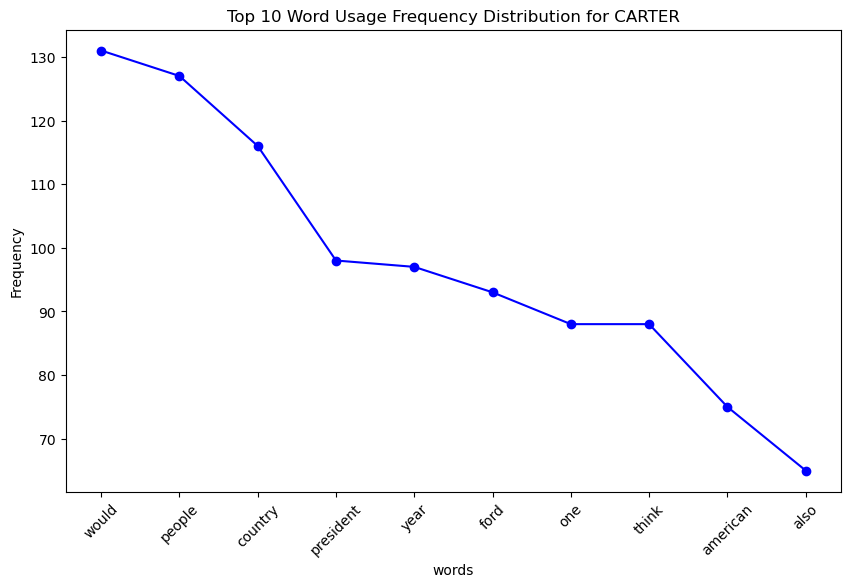

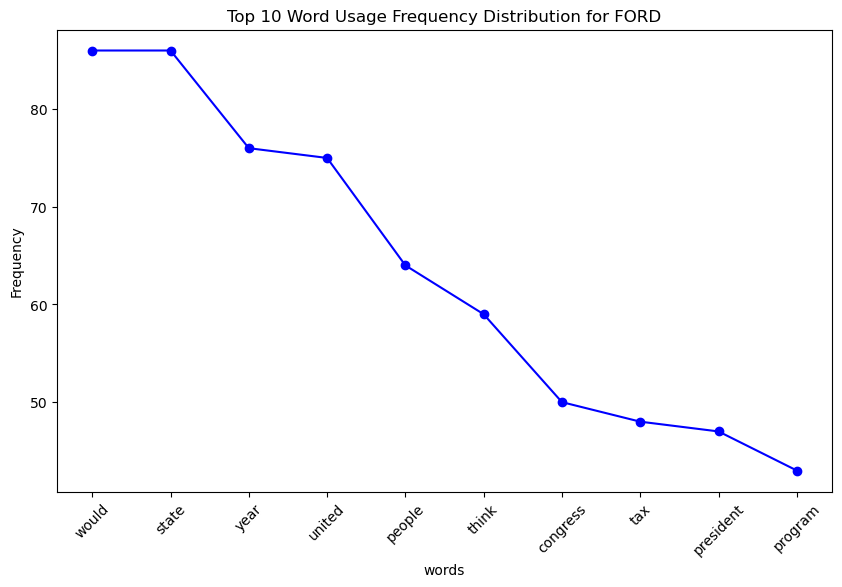

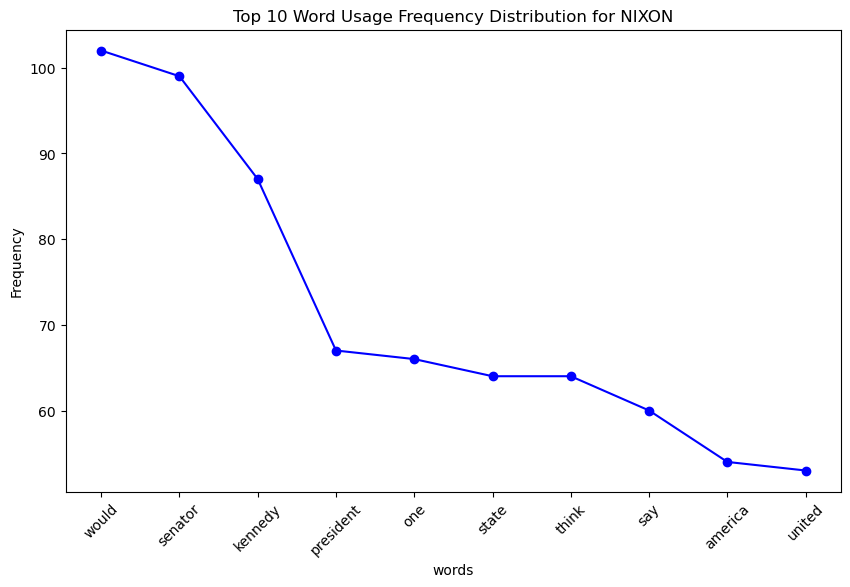

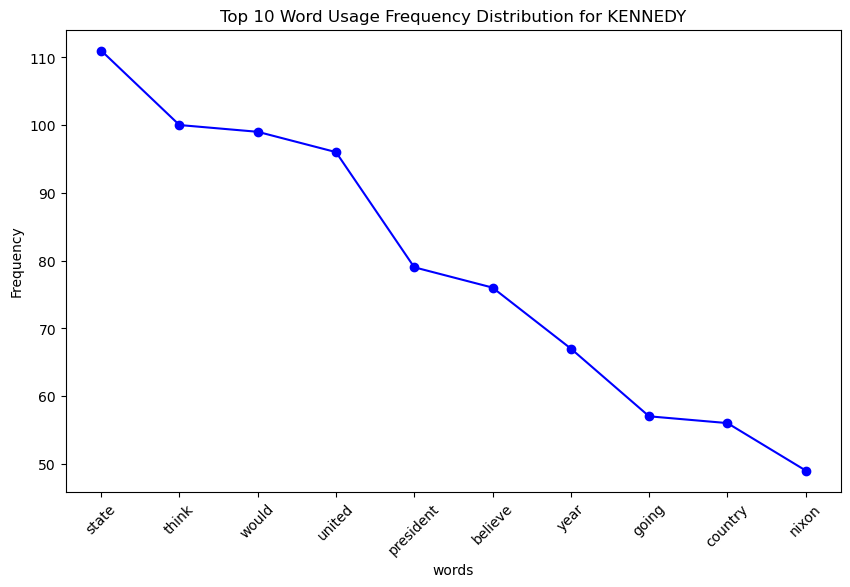

In [122]:
# Create a frequency distribution for each speaker
speaker_freq_dist = {}
for speaker in result_df['Name'].unique():
    #tokens = [token for sublist in result_df[result_df['Name'] == speaker]['tokens'] for token in sublist]
    tokens = [token for sublist in result_df[result_df['Name'] == speaker]['list_tokens'] for token in sublist]

    freq_dist = FreqDist(tokens)
    
    # Check if the frequency distribution is not empty
    if freq_dist and freq_dist.N():
        # Get the top 10 tokens
        top_tokens = freq_dist.most_common(10)
        
        # Create a frequency distribution for the top 10 tokens
        top_freq_dist = FreqDist(dict(top_tokens))
        speaker_freq_dist[speaker] = top_freq_dist

# Plot the frequency distribution for each speaker using a line graph
for speaker, freq_dist in speaker_freq_dist.items():
    plt.figure(figsize=(10, 6))
    
    # Extract words and frequencies
    words, frequencies = zip(*freq_dist.items())
    tickvals = range(0,len(words))
    
# Use Pandas Series plot function with kind='line'
    pd.Series(frequencies, index=words).plot(kind='line', marker='o', linestyle='-', color='b')
    
    plt.title(f"Top 10 Word Usage Frequency Distribution for {speaker}")
    plt.xlabel("words")
    plt.ylabel("Frequency")
    plt.xticks(ticks=tickvals, labels= words, rotation=45)
    plt.show()

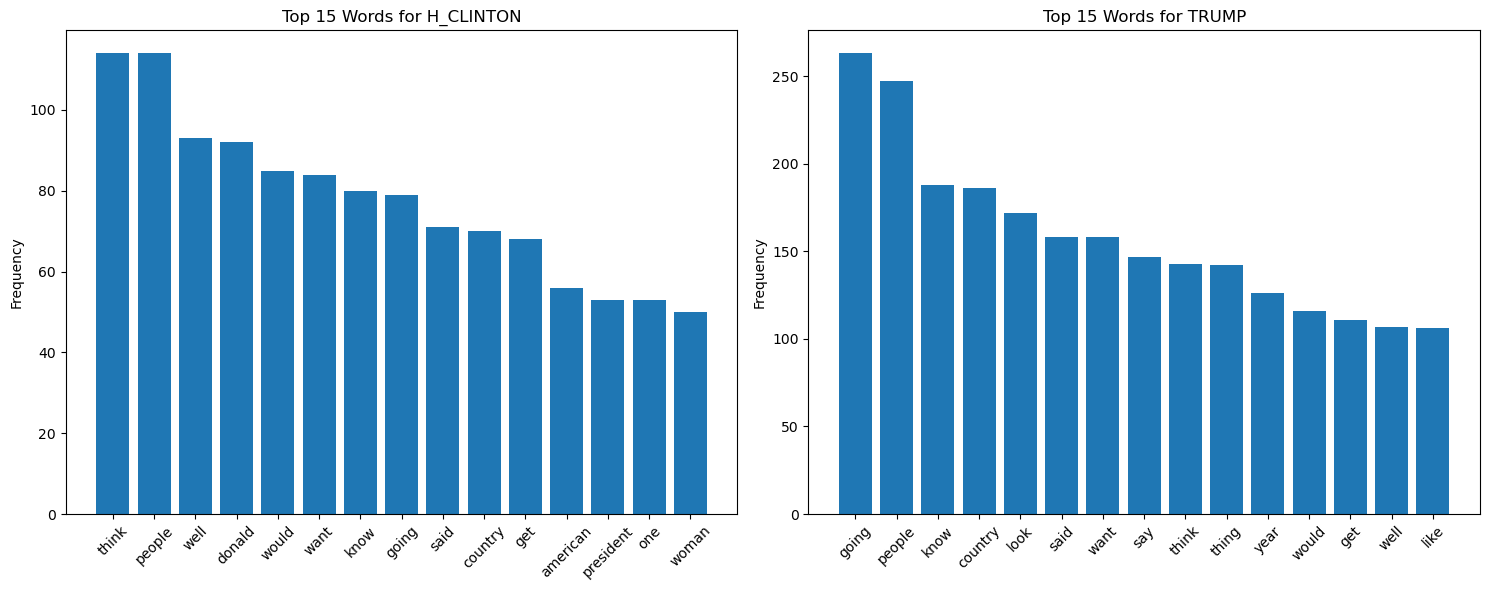

In [123]:
def plot_speaker_comparison(speaker1, speaker2, df, num_words=15):
    """
    Plot the top 'num_words' used by two speakers side by side.

    :param speaker1: Name of the first speaker.
    :param speaker2: Name of the second speaker.
    :param df: DataFrame containing the speakers and tokens.
    :param num_words: Number of top words to plot (default is 15).
    """
    
    # Initialize subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Loop over speakers
    for idx, speaker in enumerate([speaker1, speaker2]):
        # Extract tokens for the speaker
        tokens = [token for token_list in df[df['Name'] == speaker]['list_tokens'] for token in token_list]

        # Create frequency distribution and get top tokens
        freq_dist = FreqDist(tokens)
        top_tokens = freq_dist.most_common(num_words)

        # Extract words and frequencies
        words, frequencies = zip(*top_tokens)

        # Plot
        axes[idx].bar(words, frequencies)
        axes[idx].set_title(f"Top {num_words} Words for {speaker}")
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example usage
plot_speaker_comparison('H_CLINTON', 'TRUMP', result_df)

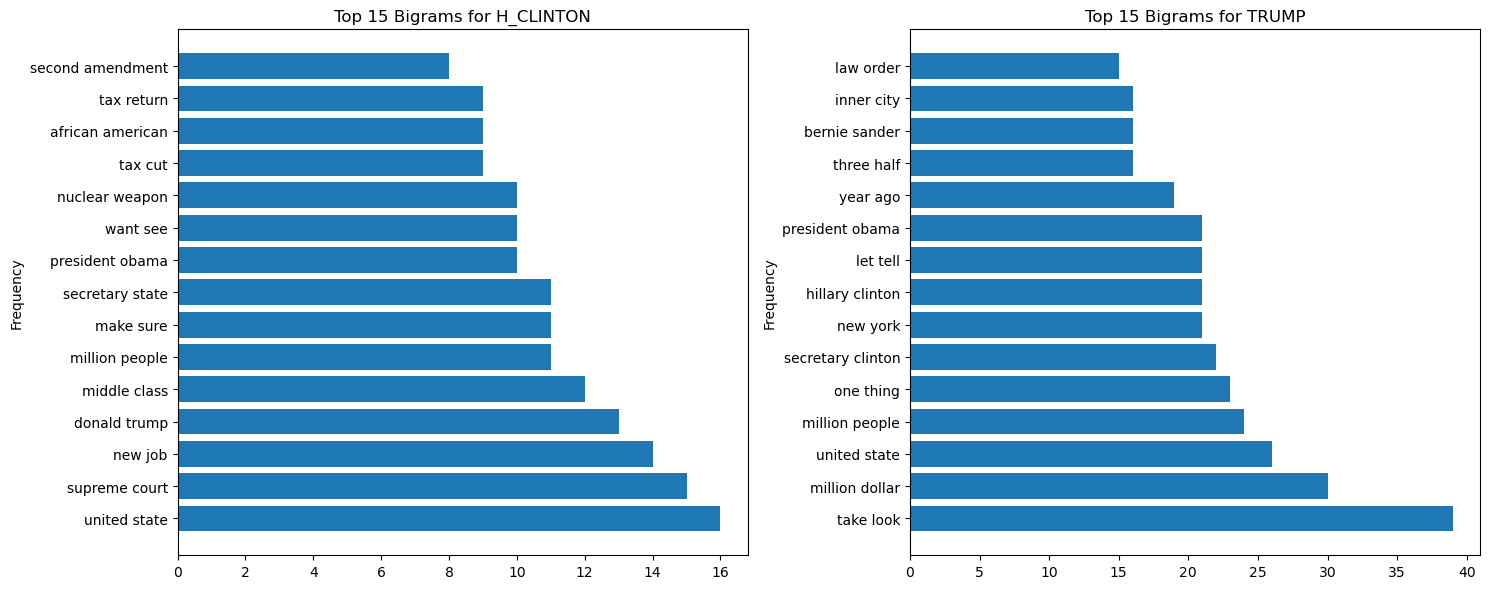

In [207]:
from nltk import FreqDist, bigrams as bg, trigrams
from itertools import chain
def plot_speaker_comparison_bigrams(speaker1, speaker2, df, num_words=15):
    """
    Plot the top 'num_words' bigrams used by two speakers side by side.

    :param speaker1: Name of the first speaker.
    :param speaker2: Name of the second speaker.
    :param df: DataFrame containing the speakers and tokens.
    :param num_words: Number of top bigrams to plot (default is 15).
    """

    # Initialize subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Loop over speakers
    for idx, speaker in enumerate([speaker1, speaker2]):
        # Extract tokens for the speaker
        token_lists = df[df['Name'] == speaker]['list_tokens']
        
        # Create bigrams from the list of tokens
        bigram_list = list(chain(*[bg(token_list) for token_list in token_lists]))

        # Create frequency distribution and get top bigrams
        freq_dist = FreqDist(bigram_list)
        top_bigrams = freq_dist.most_common(num_words)

        # Extract bigrams and frequencies
        bigrams, frequencies = zip(*top_bigrams)
        bigram_labels = [' '.join(bigram) for bigram in bigrams]

        # Plot
        axes[idx].barh(bigram_labels, frequencies)
        axes[idx].set_title(f"Top {num_words} Bigrams for {speaker}")
        axes[idx].tick_params(axis='x')
        axes[idx].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example usage
plot_speaker_comparison_bigrams('H_CLINTON', 'TRUMP', result_df)

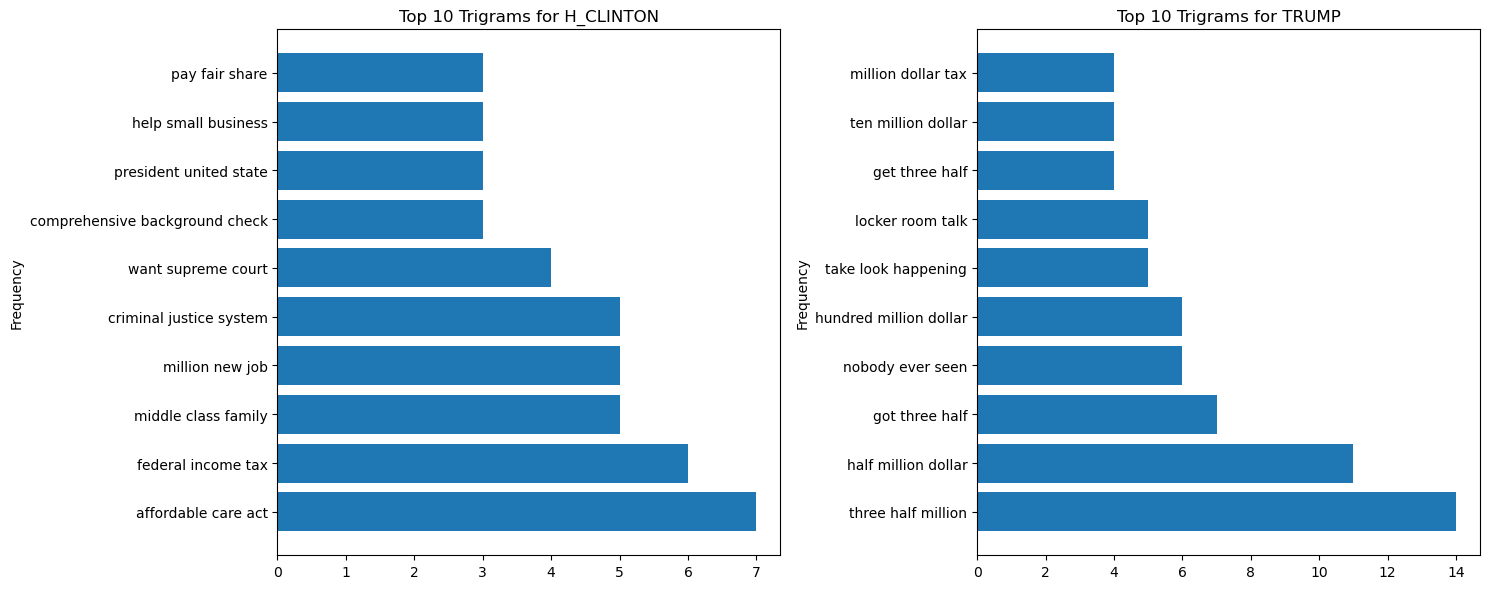

In [208]:
def plot_speaker_comparison_trigrams(speaker1, speaker2, df, num_trigrams=10):
    """
    Plot the top 'num_trigrams' trigrams used by two speakers side by side.

    :param speaker1: Name of the first speaker.
    :param speaker2: Name of the second speaker.
    :param df: DataFrame containing the speakers and tokens.
    :param num_trigrams: Number of top trigrams to plot (default is 10).
    """

    # Initialize subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Loop over speakers
    for idx, speaker in enumerate([speaker1, speaker2]):
        # Extract tokens for the speaker
        token_lists = df[df['Name'] == speaker]['list_tokens']
        
        # Create trigrams from the list of tokens
        trigram_list = list(chain(*[trigrams(token_list) for token_list in token_lists]))

        # Create frequency distribution and get top trigrams
        freq_dist = FreqDist(trigram_list)
        top_trigrams = freq_dist.most_common(num_trigrams)

        # Extract trigrams and frequencies
        trigram_tuples, frequencies = zip(*top_trigrams)
        trigram_labels = [' '.join(trigram) for trigram in trigram_tuples]

        # Plot
        axes[idx].barh(trigram_labels, frequencies)
        axes[idx].set_title(f"Top {num_trigrams} Trigrams for {speaker}")
        axes[idx].tick_params(axis='x')
        axes[idx].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example usage
plot_speaker_comparison_trigrams('H_CLINTON', 'TRUMP', result_df)

### 3.g. Additional Stopwords Removal

[[0.64037871 0.35962129]
 [0.59764323 0.40235677]
 [0.41218361 0.58781639]
 [0.54586092 0.45413908]
 [0.48900488 0.51099512]
 [0.42859913 0.57140087]
 [0.5277701  0.4722299 ]
 [0.50628413 0.49371587]
 [0.50498825 0.49501175]
 [0.59932362 0.40067638]
 [0.63669166 0.36330834]
 [0.51578273 0.48421727]
 [0.60899887 0.39100113]
 [0.56482949 0.43517051]
 [0.57316232 0.42683768]
 [0.55988596 0.44011404]
 [0.57688194 0.42311806]
 [0.60776828 0.39223172]]


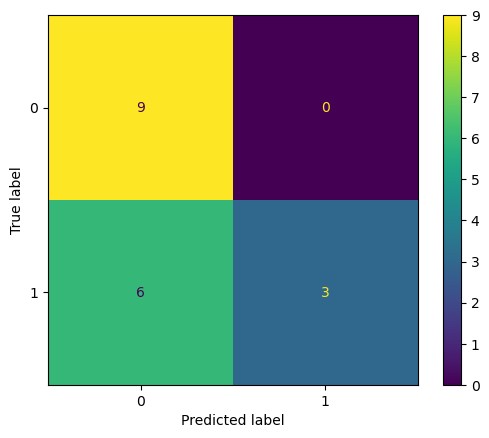

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

X = result_df[["list_tokens"]]
y = result_df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# vectorizer
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["list_tokens"].apply(lambda x: " ".join(x)))
X_test_tfidf = tfidf_vectorizer.transform(X_test["list_tokens"].apply(lambda x: " ".join(x)))

# Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# print multinomial probabilities 
print(clf.predict_proba(X_test_tfidf))

In [132]:
# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.transform(result_df["list_tokens"].apply(lambda x: " ".join(x)))

# Create a new column "tfidf" in the dataframe with the vectorized data
result_df["tfidf"] = tfidf_matrix.toarray().tolist()

result_df

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,tfidf
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,"[0.026527023874783173, 0.013198888683408946, 0..."
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,"[0.017559477111987208, 0.014561602338933116, 0..."
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0,"how are you, donald? [applause] well, thank ...","[donald, applause, well, thank, lester, thanks...",donald applause well thank lester thanks hofst...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0193336973207..."
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, jim, thanks, peo...",going applaud well thank jim thanks people san...,"[0.03824262242342994, 0.013591533748245746, 0...."
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0,"thank you, jim. and thank you to the people o...","[thank, jim, thank, people, hartford, host, wa...",thank jim thank people hartford host want begi...,"[0.041664850957340675, 0.02303436058231807, 0...."
...,...,...,...,...,...,...,...,...
153,1960,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,"mr. smith, senator kennedy. the things that s...","[smith, senator, kennedy, thing, senator, kenn...",smith senator kennedy thing senator kennedy sa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
158,1960,KENNEDY,"Good evening, Mr. Howe. MR. Mr. Howe, Mr. Vi...",0,"good evening, mr. howe. mr. mr. howe, mr. vi...","[good, evening, howe, howe, vice, president, f...",good evening howe howe vice president first le...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
159,1960,KENNEDY,"Good evening, Mr. Shadel. MR. Mr. McGee, we ...",0,"good evening, mr. shadel. mr. mr. mcgee, we ...","[good, evening, shadel, mcgee, contractual, ri...",good evening shadel mcgee contractual right be...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
160,1960,KENNEDY,In the first place I’ve never suggested that ...,0,in the first place i’ve never suggested that ...,"[first, place, never, suggested, cuba, lost, e...",first place never suggested cuba lost except p...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [133]:
proba = clf.predict_proba(result_df["tfidf"].to_list())
result_df["proba"] = proba.tolist()
result_df["prob_0"] = result_df["proba"].apply(lambda x: x[0])
result_df["prob_1"] = result_df["proba"].apply(lambda x: x[1])
result_df["difference"] = result_df["prob_0"] - result_df["prob_1"]
result_df

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,tfidf,proba,prob_0,prob_1,difference
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,"[0.026527023874783173, 0.013198888683408946, 0...","[0.6757731713321085, 0.3242268286678859]",0.675773,0.324227,0.351546
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,"[0.017559477111987208, 0.014561602338933116, 0...","[0.6849553366242681, 0.3150446633757302]",0.684955,0.315045,0.369911
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0,"how are you, donald? [applause] well, thank ...","[donald, applause, well, thank, lester, thanks...",donald applause well thank lester thanks hofst...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0193336973207...","[0.6089988714957326, 0.39100112850426866]",0.608999,0.391001,0.217998
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, jim, thanks, peo...",going applaud well thank jim thanks people san...,"[0.03824262242342994, 0.013591533748245746, 0....","[0.7265464541279167, 0.273453545872084]",0.726546,0.273454,0.453093
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0,"thank you, jim. and thank you to the people o...","[thank, jim, thank, people, hartford, host, wa...",thank jim thank people hartford host want begi...,"[0.041664850957340675, 0.02303436058231807, 0....","[0.7641559433583383, 0.23584405664167168]",0.764156,0.235844,0.528312
...,...,...,...,...,...,...,...,...,...,...,...,...
153,1960,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,"mr. smith, senator kennedy. the things that s...","[smith, senator, kennedy, thing, senator, kenn...",smith senator kennedy thing senator kennedy sa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3506811543636707, 0.6493188456363357]",0.350681,0.649319,-0.298638
158,1960,KENNEDY,"Good evening, Mr. Howe. MR. Mr. Howe, Mr. Vi...",0,"good evening, mr. howe. mr. mr. howe, mr. vi...","[good, evening, howe, howe, vice, president, f...",good evening howe howe vice president first le...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5458609171526554, 0.45413908284733184]",0.545861,0.454139,0.091722
159,1960,KENNEDY,"Good evening, Mr. Shadel. MR. Mr. McGee, we ...",0,"good evening, mr. shadel. mr. mr. mcgee, we ...","[good, evening, shadel, mcgee, contractual, ri...",good evening shadel mcgee contractual right be...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6767311941203547, 0.32326880587963946]",0.676731,0.323269,0.353462
160,1960,KENNEDY,In the first place I’ve never suggested that ...,0,in the first place i’ve never suggested that ...,"[first, place, never, suggested, cuba, lost, e...",first place never suggested cuba lost except p...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6396972081805047, 0.36030279181950764]",0.639697,0.360303,0.279394


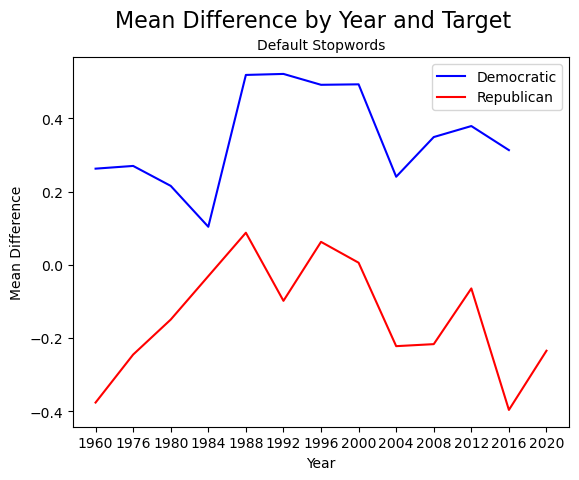

In [138]:

# Group the data by "Target" and calculate the mean of "difference"
grouped_data = result_df.groupby(["Year", "Target"])["difference"].mean()
grouped_data = grouped_data.reset_index()

# Iterate over each group and plot a line graph
for target, data in grouped_data.groupby("Target"):
    if target == 0:
        plt.plot(data['Year'], data['difference'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['Year'], data['difference'], label=f"Target {target}", color='red')

# Set the title and labels for the plot
plt.suptitle("Mean Difference by Year and Target", fontsize=16)
plt.title("Default Stopwords", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Mean Difference")

# Set custom legend names
legend_names = ["Democratic", "Republican"]  # Replace with your desired legend names
plt.legend(legend_names)


In [140]:
features = pd.DataFrame((zip(tfidf_vectorizer.get_feature_names_out(), clf.feature_log_prob_[0], clf.feature_log_prob_[1])))
features["diff"] = features[2] - features[1]
features.sort_values(by="diff")[:50]

,0,1,2,diff
1176,bush,-8.143564,-8.980355,-0.836790
6526,romney,-8.384586,-9.081297,-0.696711
2434,dole,-8.407930,-8.971749,-0.563820
2443,donald,-8.488478,-9.041908,-0.553430
4727,mccain,-8.523498,-9.034907,-0.511409
2984,family,-8.200978,-8.664835,-0.463857
5100,nixon,-8.573903,-9.017776,-0.443872
3174,ford,-8.448648,-8.864857,-0.416209
3615,health,-8.219363,-8.627289,-0.407926
3353,george,-8.638223,-9.031254,-0.393030


In [143]:
stops_dem = ["mccain", "bush", "donald", "romney", "ford", "nixon", "george", "john", "dole", "dan", "richard", "reagan", "trump", "quayle", "jim"]

In [141]:
features.sort_values(by="diff")[-50:]

,0,1,2,diff
2582,eisenhower,-9.003763,-8.820544,0.183219
483,amendment,-8.928550,-8.744877,0.183672
4128,iran,-8.813853,-8.629480,0.184373
6157,recommendation,-9.019565,-8.832836,0.186729
6914,sit,-9.032881,-8.842106,0.190775
1208,call,-8.969289,-8.777452,0.191837
2075,defeat,-9.047850,-8.855889,0.191961
2137,demonstration,-9.097064,-8.900238,0.196826
1577,communism,-9.084747,-8.887745,0.197002
5598,place,-8.779713,-8.581834,0.197878


In [144]:
stops_rep = ["obama", "hillary", "joe", "clinton", "carter", "khrushchev", "kennedy", "biden", "crosstalk", "bernie", "sander"]
add_stopwords = stops_dem + stops_rep

In [256]:
# Function to remove stopwords from a string
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in add_stopwords]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the 'string_tokens' column
final_df['string_tokens'] = final_df['string_tokens'].apply(lambda x: remove_stopwords(x))
# Recreate list_tokens column from new string_tokens
final_df['list_tokens'] = final_df['string_tokens'].apply(lambda x: x.split())

# Display the updated DataFrame
final_df.head()


,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,link,tfidf,proba,prob_0,prob_1,difference
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0.0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,NaN,"[0.0, 0.0, 0.03851994499519411, 0.037371654409...","[0.6307787056649465, 0.3692212943350467]",0.630779,0.369221,-0.261557
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0.0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0266042011987...","[0.7898602484610072, 0.21013975153899833]",0.789860,0.210140,-0.579720
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0.0,"how are you, donald? [applause] well, thank ...","[applause, well, thank, lester, thanks, hofstr...",applause well thank lester thanks hofstra host...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7098848581917827, 0.29011514180821135]",0.709885,0.290115,-0.419770
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0.0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, thanks, people, ...",going applaud well thank thanks people san die...,NaN,"[0.02938256946149696, 0.0, 0.02643368859057811...","[0.7391619388440556, 0.2608380611559481]",0.739162,0.260838,-0.478324
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0.0,"thank you, jim. and thank you to the people o...","[thank, thank, people, hartford, host, want, b...",thank thank people hartford host want begin sa...,NaN,"[0.0, 0.0, 0.03406743563246988, 0.0, 0.0, 0.0,...","[0.7239755826200168, 0.2760244173799821]",0.723976,0.276024,-0.447951


Finally we can save off our final dataset

In [147]:
final_df.to_csv('data/final_df.csv', index=False)

## 4. Modelling

In [148]:
# Checking that our columns of interest have no nulls
final_df.isna().sum()

Year              0
Name              0
Text              0
Target            0
text_lower       32
list_tokens       0
string_tokens     0
link             72
dtype: int64

In [149]:
# Checking that the tokens column is in fact one string
final_df['string_tokens'][1]

1    well thank teacher yes think good question hea...
1    thank much thank amazing welcome thank great c...
1    fellow countryman occasion oath taken god mine...
Name: string_tokens, dtype: object

First we define some functions that will make it easier for us to evaluate our grid searches of each future model type.

"evaluate_grid" will output the parameters of the best model, the validation accuracy score, and the training data accuracy score.

"plot_cm" will output the confusion matrix for the best model.

In [150]:
def evaluate_grid(gs):
    y_pred = gs.predict(X_test)
    print("Best Params: " + str(gs.best_params_)) 
    print("Best CV Accuracy: " + str(gs.best_score_)) 
    print("Train Accuracy: " + str(gs.score(X_train, y_train)))

In [162]:
def plot_cm(y_test, gs):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    y_pred = gs.predict(X_test)    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['dem', 'rep'])
    disp.plot();

In [152]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(final_df["string_tokens"], final_df['Target'], random_state=42)

### 4.a. Multinomial Naive Bayes Model

We instatiate a Multinomial Naive Bayes model. This model uses Bayes probability to statistically test the hypothesis that a text of a document belongs to a certain class (in this case, a political party). 

We also instatiate a Tf-Idf Vectorizer. This type of vectorizer is very powerful for content-based classification because adds importance weight to certain tokens
- A vectorizer turns the inputted text into a document term matrix: a matrix where each row is one speech by one speaker. Each column is a unique vocabulary n-gram (a token/word) whose cell has the tf-idf score of that token/word in that document. Each row is a numerical vector, which is what makes words usable in our model.
- A tf-idf score is a combination of a tf or "term frequency" score, which measures the frequency of that word in that document, and an idf or "inverse document frequency" score, which measures the frequency of that word across the full corpus. So, the higher the tf-idf score, the more important that word is in that document compared to how important it is in all the documents.

In [153]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()), 
    ('mnb', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [154]:
cross_val_score(pipe, X_train, y_train)

array([0.5       , 0.5       , 0.66666667, 0.66666667, 0.47058824])

In [155]:
pipe.score(X_test, y_test)

0.4666666666666667

Without any parameter tuning, our model performs badly, getting the text classification right less than half the time.

#### 4.a.i. MNB Grid Searches

We grid search and cross validate different versions of that pipeline with different hyperparameters.

In [156]:
gs = GridSearchCV(pipe, param_grid= {
    'tfidf__max_df': [0.75, 0.9, 1.0], # default 1.0
    'tfidf__min_df': [0.0, 0.05, 0.1], # default 1
    'tfidf__ngram_range': [(1, 1), (1, 2)], # default (1,1)
    'tfidf__max_features': [None, 2, 20], # default (None)
    'tfidf__norm': ['l1', 'l2', None]
})
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.75, 0.9, 1.0],
                         'tfidf__max_features': [None, 2, 20],
                         'tfidf__min_df': [0.0, 0.05, 0.1],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__norm': ['l1', 'l2', None]})

In [159]:
# Calling our custom function
evaluate_grid(gs)

Best Params: {'tfidf__max_df': 1.0, 'tfidf__max_features': None, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': None}
Best CV Accuracy: 0.8084967320261438
Train Accuracy: 0.9887640449438202


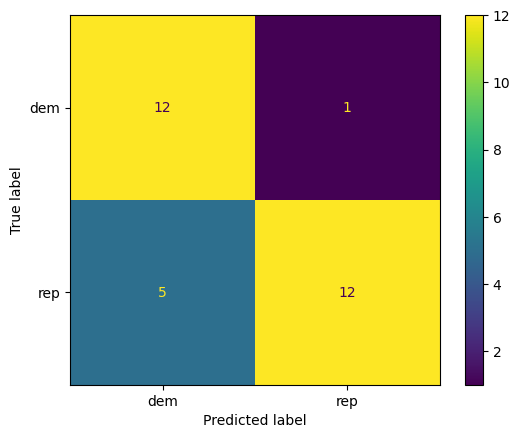

In [163]:
# plotting confusion matrix
plot_cm(y_test, gs)

Using the best parameters ouputted from our "evaluate_grid" custom function, we edit the grid search hyperparameters and grid search again. We will iterate through this process in 4 different grid searches in order to try and improve our scores as much as possible.

In [164]:
gs2 = GridSearchCV(pipe, param_grid= {
    'tfidf__max_df': [0.95, 1.0], # default 1.0 was best
    'tfidf__min_df': [0.0, 0.05], # default 1, 0 was best
    'tfidf__ngram_range': [(2, 2), (1, 2)], # default (1,1)
    'tfidf__max_features': [None, 1], # default (None) was best
    'tfidf__norm': ['l1', 'l2', None] # best was None
})
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.95, 1.0],
                         'tfidf__max_features': [None, 1],
                         'tfidf__min_df': [0.0, 0.05],
                         'tfidf__ngram_range': [(2, 2), (1, 2)],
                         'tfidf__norm': ['l1', 'l2', None]})

In [165]:
evaluate_grid(gs2)

Best Params: {'tfidf__max_df': 0.95, 'tfidf__max_features': None, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (2, 2), 'tfidf__norm': None}
Best CV Accuracy: 0.8529411764705882
Train Accuracy: 0.9887640449438202


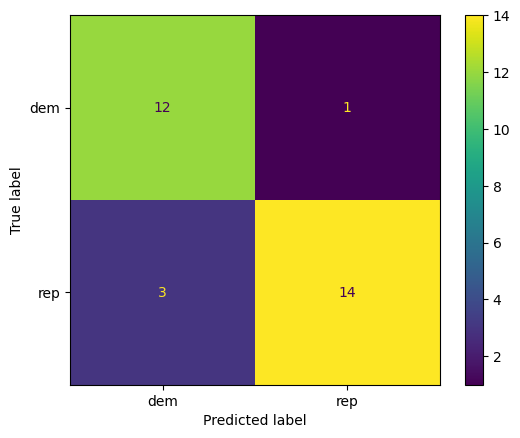

In [166]:
plot_cm(y_test, gs2)

In [167]:
gs3 = GridSearchCV(pipe, param_grid= {
    'tfidf__max_df': [0.95, 1.0], # earlier 0.95 was best
    'tfidf__min_df': [0.05, 0.0], # 0.05 was best
    'tfidf__ngram_range': [(2,2), (1,2), (1,3)], # default (1,1)
   'tfidf__max_features': [None, 1], # default (None) was best so commenting it out
    'tfidf__norm': [None] # None was best
})
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.95, 1.0],
                         'tfidf__max_features': [None, 1],
                         'tfidf__min_df': [0.05, 0.0],
                         'tfidf__ngram_range': [(2, 2), (1, 2), (1, 3)],
                         'tfidf__norm': [None]})

In [168]:
evaluate_grid(gs3)

Best Params: {'tfidf__max_df': 0.95, 'tfidf__max_features': None, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (2, 2), 'tfidf__norm': None}
Best CV Accuracy: 0.8529411764705882
Train Accuracy: 0.9887640449438202


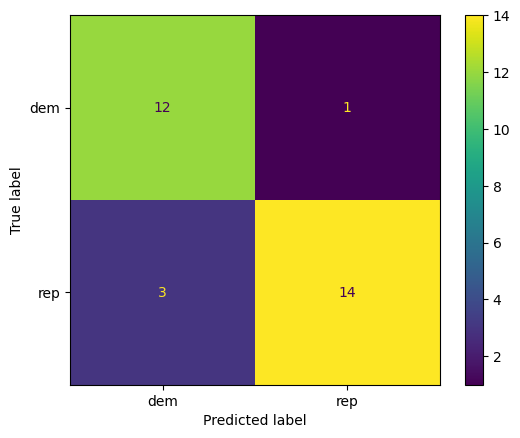

In [169]:
plot_cm(y_test, gs3)

In [170]:
gs4 = GridSearchCV(pipe, param_grid= {
    'tfidf__max_df': [0.3, 0.35, 0.4, 0.45], # earlier 0.4 was best
    'tfidf__min_df': [0.0], # 0.0 was best
    'tfidf__ngram_range': [(2,2), (3,3)], # default (1,1)
   'tfidf__max_features': [None, 2, 20], # default (None) was best so commenting it out
    'tfidf__norm': [None] # None was best
})
gs4.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.3, 0.35, 0.4, 0.45],
                         'tfidf__max_features': [None, 2, 20],
                         'tfidf__min_df': [0.0],
                         'tfidf__ngram_range': [(2, 2), (3, 3)],
                         'tfidf__norm': [None]})

In [171]:
evaluate_grid(gs4)

Best Params: {'tfidf__max_df': 0.3, 'tfidf__max_features': None, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (3, 3), 'tfidf__norm': None}
Best CV Accuracy: 0.8967320261437909
Train Accuracy: 0.9887640449438202


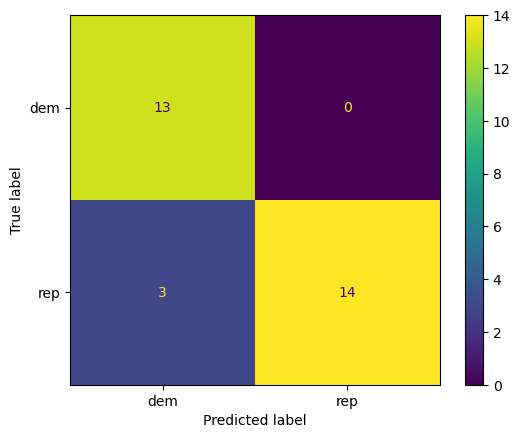

In [172]:
plot_cm(y_test, gs4)

Our scores past grid search 2 did not improve, so we will assign it as our best model and score it on testing data

In [173]:
gs2.score(X_test, y_test)

0.8666666666666667

### 4.b. Gaussian Bayes Model

#### 4.b.i. GB Grid Searches

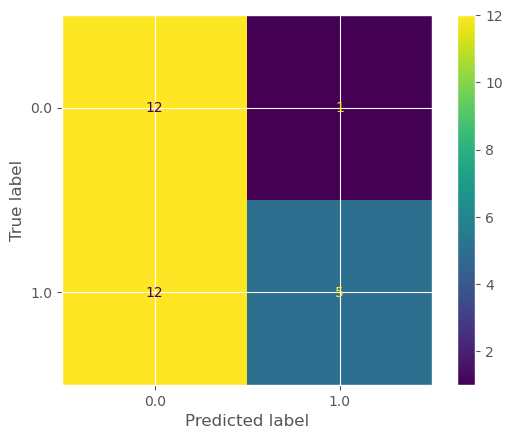

In [257]:
from sklearn.naive_bayes import GaussianNB

X = final_df[["list_tokens"]]
y = final_df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["list_tokens"].apply(lambda x: " ".join(x)))
X_test_tfidf = tfidf_vectorizer.transform(X_test["list_tokens"].apply(lambda x: " ".join(x)))

clf = GaussianNB()
clf.fit(X_train_tfidf.toarray(), y_train)
y_pred = clf.predict(X_test_tfidf.toarray())

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

### 4.c. Random Forest Model

For text data, the document term matrix returned by a vectorizer is typically a sparse matrix, since there are many tokens that each document does not have (i.e. there are lots of 0 values). This means our model has a very high number of features/columns/words. Tree-based models work very well with high dimensional data, so we instatiate and grid search a Random Forest model below. 

In [195]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(final_df["string_tokens"], final_df['Target'], random_state=42)
pipe3 = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()), 
    ('rf', RandomForestClassifier(random_state=42))])
pipe3.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf', RandomForestClassifier(random_state=42))])

In [196]:
pipe3.score(X_train, y_train)

1.0

In [197]:
cross_val_score(pipe3, X_train, y_train)

array([0.77777778, 0.83333333, 0.83333333, 0.5       , 0.64705882])

#### 4.c.i. RF Grid Searches

In [198]:
gs_rf = GridSearchCV(pipe3, param_grid = {
        'rf__max_depth': [None, 5, 10],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 5, 10],
        'rf__n_estimators': [100, 200, 300],
})
gs_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__min_samples_leaf': [1, 5, 10],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]})

In [199]:
evaluate_grid(gs_rf)

Best Params: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best CV Accuracy: 0.7633986928104576
Train Accuracy: 1.0


In [200]:
gs2_rf = GridSearchCV(pipe3, param_grid = {
        'rf__max_depth': [None, 1],
        'rf__min_samples_split': [2, 3, 1],
        'rf__min_samples_leaf': [4, 5, 6],
        'rf__n_estimators': [190, 200, 210],
})
gs2_rf.fit(X_train, y_train)

/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/p

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [None, 1],
                         'rf__min_samples_leaf': [4, 5, 6],
                         'rf__min_samples_split': [2, 3, 1],
                         'rf__n_estimators': [190, 200, 210]})

In [201]:
evaluate_grid(gs2_rf)

Best Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 190}
Best CV Accuracy: 0.7411764705882353
Train Accuracy: 1.0


Our random forest model did not perform better than our best Multinomial Bayes model.

In [295]:
final_rf = gs2_rf.best_estimator_
final_rf.steps[1][1].feature_importances_

array([0.0007803, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ])

## 5. Final Results: Multinomial Naive Bayes Model

Our best model is a Multinomial Naive Bayes model. On our training dataset, when our model classified whether a speech was made by a Democrat or a Republican it was right 98% of the time. On unseen testing data, its classification was right 87% of the time.

The model is overfit, which means it could use further tuning to reduce this disparity. One such possible method is Principal Component Analysis. PCA reduces the number of features (and thus the complexity of the model) by creating components consisting of similar features, ones that move in a similar direction. Our group did not have the time for this method, but we consider it in our next steps. 

Overall, we’re still getting highly accurate party predictions based just on what a candidate said.

In [258]:
final_clf = gs2.best_estimator_
final_clf

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(2, 2),
                                 norm=None)),
                ('mnb', MultinomialNB())])

In [259]:
X = final_df[["list_tokens"]]
y = final_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(2, 2), smooth_idf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["list_tokens"].apply(lambda x: " ".join(x)))
X_test_tfidf = tfidf_vectorizer.transform(X_test["list_tokens"].apply(lambda x: " ".join(x)))

final_clf = MultinomialNB()
final_clf.fit(X_train_tfidf, y_train)
y_pred = final_clf.predict(X_test_tfidf)

# print multinomial probabilities 
print(final_clf.predict_proba(X_test_tfidf))


[[0.60956333 0.39043667]
 [0.54948494 0.45051506]
 [0.7279362  0.2720638 ]
 [0.67399729 0.32600271]
 [0.46287556 0.53712444]
 [0.44508797 0.55491203]
 [0.57256708 0.42743292]
 [0.44851214 0.55148786]
 [0.66767605 0.33232395]
 [0.67508921 0.32491079]
 [0.67203054 0.32796946]
 [0.62559405 0.37440595]
 [0.46934585 0.53065415]
 [0.57325887 0.42674113]
 [0.38974754 0.61025246]
 [0.42428704 0.57571296]
 [0.55828841 0.44171159]
 [0.62047462 0.37952538]
 [0.54101789 0.45898211]
 [0.55601871 0.44398129]
 [0.43484009 0.56515991]
 [0.70210219 0.29789781]
 [0.55357304 0.44642696]
 [0.46577492 0.53422508]
 [0.6058122  0.3941878 ]
 [0.36727719 0.63272281]
 [0.60617015 0.39382985]
 [0.57141693 0.42858307]
 [0.5358428  0.4641572 ]
 [0.44119235 0.55880765]]


In [260]:
# Fit and transform all of the text data
tfidf_matrix = tfidf_vectorizer.transform(final_df["list_tokens"].apply(lambda x: " ".join(x)))

# Create a new column "tfidf" in the dataframe with the vectorized data
final_df["tfidf"] = tfidf_matrix.toarray().tolist()

final_df

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,link,tfidf,proba,prob_0,prob_1,difference
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0.0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,NaN,"[0.0, 0.0, 0.04008664202057055, 0.038891647747...","[0.6307787056649465, 0.3692212943350467]",0.630779,0.369221,-0.261557
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0.0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0280462969802...","[0.7898602484610072, 0.21013975153899833]",0.789860,0.210140,-0.579720
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0.0,"how are you, donald? [applause] well, thank ...","[applause, well, thank, lester, thanks, hofstr...",applause well thank lester thanks hofstra host...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7098848581917827, 0.29011514180821135]",0.709885,0.290115,-0.419770
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0.0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, thanks, people, ...",going applaud well thank thanks people san die...,NaN,"[0.032476718727271, 0.0, 0.029217304170945063,...","[0.7391619388440556, 0.2608380611559481]",0.739162,0.260838,-0.478324
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0.0,"thank you, jim. and thank you to the people o...","[thank, thank, people, hartford, host, want, b...",thank thank people hartford host want begin sa...,NaN,"[0.0, 0.0, 0.0514030578692446, 0.0, 0.0, 0.0, ...","[0.7239755826200168, 0.2760244173799821]",0.723976,0.276024,-0.447951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2005,BUSH_2,"Vice President Cheney, Mr. Chief Justice, Pres...",1.0,"vice president cheney, mr. chief justice, pres...","[vice, president, cheney, chief, justice, pres...",vice president cheney chief justice president ...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.37705104931703964, 0.6229489506829585]",0.377051,0.622949,0.245898
11,2009,OBAMA,"My fellow citizens, I stand here today humbled...",0.0,"my fellow citizens, i stand here today humbled...","[fellow, citizen, stand, today, humbled, task,...",fellow citizen stand today humbled task gratef...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7560754993027453, 0.24392450069725452]",0.756075,0.243925,-0.512151
12,2013,OBAMA,Thank you. Thank you so much. Vice President B...,0.0,thank you. thank you so much. vice president b...,"[thank, thank, much, vice, president, chief, j...",thank thank much vice president chief justice ...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7924621191708201, 0.20753788082918675]",0.792462,0.207538,-0.584924
13,2017,TRUMP,"Chief Justice Roberts, President Carter, Presi...",1.0,"chief justice roberts, president carter, presi...","[chief, justice, robert, president, president,...",chief justice robert president president presi...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4430812267684992, 0.5569187732314989]",0.443081,0.556919,0.113838


In [261]:
proba = final_clf.predict_proba(final_df["tfidf"].to_list())
final_df["proba"] = proba.tolist()
final_df["prob_0"] = final_df["proba"].apply(lambda x: x[0])
final_df["prob_1"] = final_df["proba"].apply(lambda x: x[1])
final_df["difference"] = final_df["prob_1"] - final_df["prob_0"]
final_df

,Year,Name,Text,Target,text_lower,list_tokens,string_tokens,link,tfidf,proba,prob_0,prob_1,difference
0,2016,H_CLINTON,"Thank you very much, Chris. And thanks to UNL...",0.0,"thank you very much, chris. and thanks to unl...","[thank, much, chris, thanks, unlv, hosting, kn...",thank much chris thanks unlv hosting know thin...,NaN,"[0.0, 0.0, 0.04008664202057055, 0.038891647747...","[0.6204746175760341, 0.3795253824239663]",0.620475,0.379525,-0.240949
1,2016,H_CLINTON,"Well, thank you. Are you a teacher? Yes, I th...",0.0,"well, thank you. are you a teacher? yes, i th...","[well, thank, teacher, yes, think, good, quest...",well thank teacher yes think good question hea...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0280462969802...","[0.7973167103738464, 0.20268328962614712]",0.797317,0.202683,-0.594633
2,2016,H_CLINTON,"How are you, Donald? [applause] Well, thank ...",0.0,"how are you, donald? [applause] well, thank ...","[applause, well, thank, lester, thanks, hofstr...",applause well thank lester thanks hofstra host...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7095489707283162, 0.2904510292716768]",0.709549,0.290451,-0.419098
3,1996,B_CLINTON,"I was going to applaud, too. Well, thank you,...",0.0,"i was going to applaud, too. well, thank you,...","[going, applaud, well, thank, thanks, people, ...",going applaud well thank thanks people san die...,NaN,"[0.032476718727271, 0.0, 0.029217304170945063,...","[0.7377554396245428, 0.2622445603754591]",0.737755,0.262245,-0.475511
4,1996,B_CLINTON,"Thank you, Jim. And thank you to the people o...",0.0,"thank you, jim. and thank you to the people o...","[thank, thank, people, hartford, host, want, b...",thank thank people hartford host want begin sa...,NaN,"[0.0, 0.0, 0.0514030578692446, 0.0, 0.0, 0.0, ...","[0.727936202073739, 0.27206379792626134]",0.727936,0.272064,-0.455872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2005,BUSH_2,"Vice President Cheney, Mr. Chief Justice, Pres...",1.0,"vice president cheney, mr. chief justice, pres...","[vice, president, cheney, chief, justice, pres...",vice president cheney chief justice president ...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3827995426073818, 0.6172004573926148]",0.382800,0.617200,0.234401
11,2009,OBAMA,"My fellow citizens, I stand here today humbled...",0.0,"my fellow citizens, i stand here today humbled...","[fellow, citizen, stand, today, humbled, task,...",fellow citizen stand today humbled task gratef...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7595165895058062, 0.24048341049419067]",0.759517,0.240483,-0.519033
12,2013,OBAMA,Thank you. Thank you so much. Vice President B...,0.0,thank you. thank you so much. vice president b...,"[thank, thank, much, vice, president, chief, j...",thank thank much vice president chief justice ...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7950491486172855, 0.20495085138271685]",0.795049,0.204951,-0.590098
13,2017,TRUMP,"Chief Justice Roberts, President Carter, Presi...",1.0,"chief justice roberts, president carter, presi...","[chief, justice, robert, president, president,...",chief justice robert president president presi...,https://www.presidency.ucsb.edu/documents/inau...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.44508797336489514, 0.5549120266351076]",0.445088,0.554912,0.109824


### 5.a. Bigrams Only

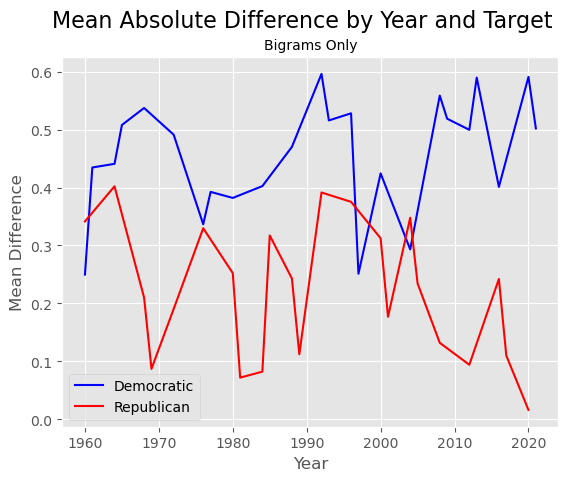

In [263]:

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
# Group the data by "Target" and calculate the mean of "difference"
final_df["Year"] = final_df["Year"].astype(int)
grouped_data = final_df.groupby(["Year", "Target"])["difference"].mean().abs()
grouped_data = grouped_data.reset_index()

# Iterate over each group and plot a line graph
for target, data in grouped_data.groupby("Target"):
    if target == 0:
        plt.plot(data['Year'], data['difference'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['Year'], data['difference'], label=f"Target {target}", color='red')

# Set the title and labels for the plot
plt.suptitle("Mean Absolute Difference by Year and Target", fontsize=16)
plt.title("Bigrams Only", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Mean Difference")

# Set custom legend names
legend_names = ["Democratic", "Republican"]  # Replace with your desired legend names
plt.legend(legend_names);




Text(50.72222222222221, 0.5, '')

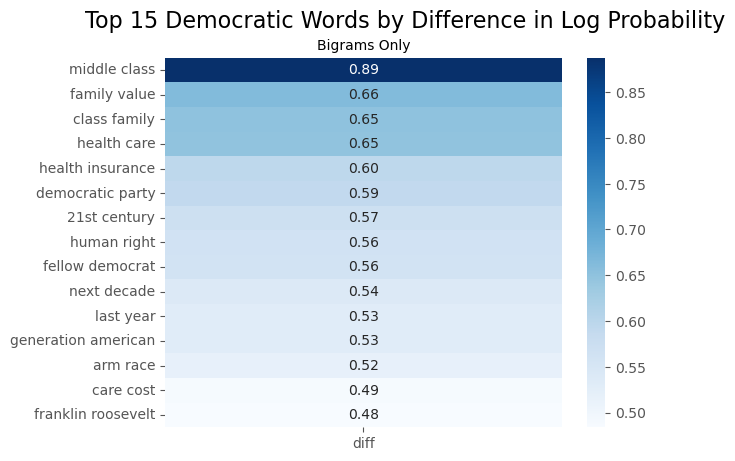

In [270]:
import seaborn as sns

features2 = pd.DataFrame((zip(tfidf_vectorizer.get_feature_names_out(), final_clf.feature_log_prob_[0], final_clf.feature_log_prob_[1])))
features2["diff"] = features2[2] - features2[1]

heatmap_df_2 = features2[[0, "diff"]].copy()
heatmap_df_2 = heatmap_df_2.rename(columns={0: "word"})
heatmap_df_2 = heatmap_df_2.sort_values(by="diff", ascending=True)
heatmap_df_2 = heatmap_df_2.set_index("word")
heatmap_df_2

sns.heatmap(heatmap_df_2[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Democratic Words by Difference in Log Probability", fontsize=16)
plt.title("Bigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")

Text(50.72222222222221, 0.5, '')

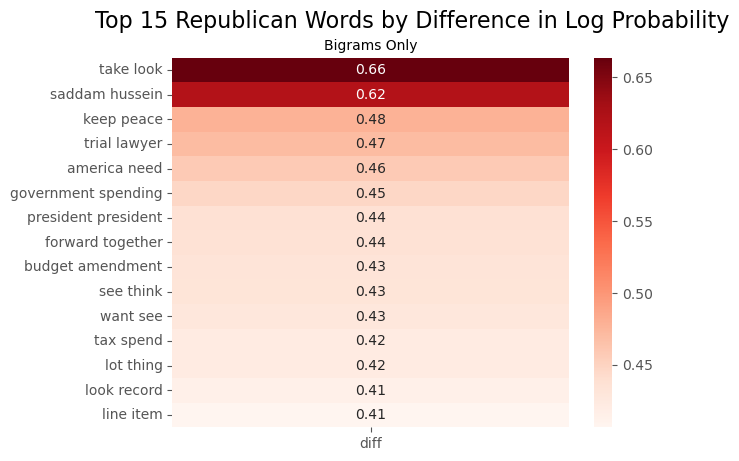

In [272]:
sns.heatmap(heatmap_df_2[-15:].abs().sort_values(by="diff", ascending=False), cmap="Reds", annot=True, fmt=".2f")
plt.suptitle("Top 15 Republican Words by Difference in Log Probability", fontsize=16)
plt.title("Bigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


### 5.b. Unigrams and Bigrams


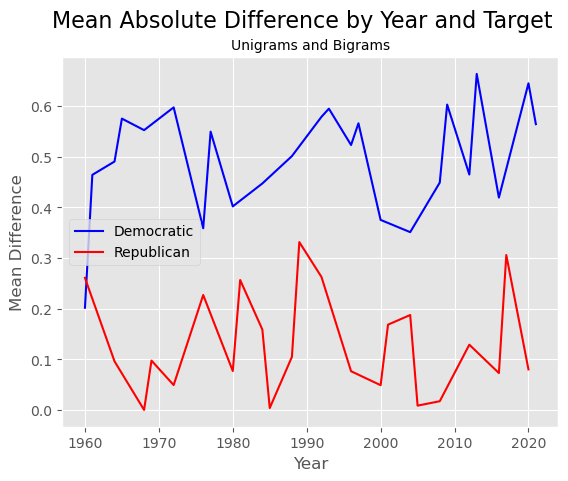

In [282]:
# repeating for both unigrams and bigrams
X = final_df[["list_tokens"]]
y = final_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tfidf_vectorizer_1 = TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 2), smooth_idf=True)
X_train_tfidf_1 = tfidf_vectorizer_1.fit_transform(X_train["list_tokens"].apply(lambda x: " ".join(x)))
X_test_tfidf_1 = tfidf_vectorizer_1.transform(X_test["list_tokens"].apply(lambda x: " ".join(x)))

final_clf_1 = MultinomialNB()
final_clf_1.fit(X_train_tfidf_1, y_train)
y_pred_1 = final_clf_1.predict(X_test_tfidf_1)

# Fit and transform all of the text data
tfidf_matrix_1 = tfidf_vectorizer_1.transform(final_df["list_tokens"].apply(lambda x: " ".join(x)))

# Create a new column "tfidf" in the dataframe with the vectorized data
final_df["tfidf"] = tfidf_matrix_1.toarray().tolist()

# Calculate proba
proba = final_clf_1.predict_proba(final_df["tfidf"].to_list())
final_df["proba_1"] = proba.tolist()
final_df["prob_1_0"] = final_df["proba"].apply(lambda x: x[0])
final_df["prob_1_1"] = final_df["proba"].apply(lambda x: x[1])
final_df["difference_1"] = final_df["prob_1_1"] - final_df["prob_1_0"]

# graph
# Group the data by "Target" and calculate the mean of "difference"
final_df["Year"] = final_df["Year"].astype(int)
grouped_data = final_df.groupby(["Year", "Target"])["difference_1"].mean().abs()
grouped_data = grouped_data.reset_index()

# Iterate over each group and plot a line graph
for target, data in grouped_data.groupby("Target"):
    if target == 0:
        plt.plot(data['Year'], data['difference_1'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['Year'], data['difference_1'], label=f"Target {target}", color='red')

# Set the title and labels for the plot
plt.suptitle("Mean Absolute Difference by Year and Target", fontsize=16)
plt.title("Unigrams and Bigrams", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Mean Difference")

# Set custom legend names
legend_names = ["Democratic", "Republican"]  # Replace with your desired legend names
plt.legend(legend_names);


Text(50.72222222222221, 0.5, '')

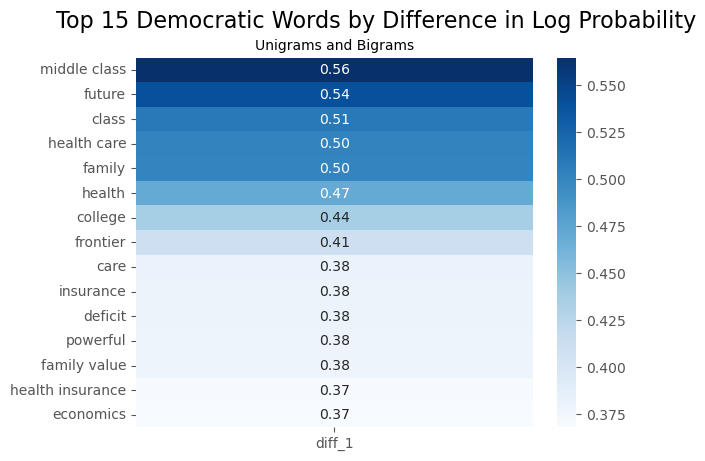

In [283]:
features1 = pd.DataFrame((zip(tfidf_vectorizer_1.get_feature_names_out(), final_clf_1.feature_log_prob_[0], final_clf_1.feature_log_prob_[1])))
features1["diff_1"] = features1[2] - features1[1]

heatmap_df_1 = features1[[0, "diff_1"]].copy()
heatmap_df_1 = heatmap_df_1.rename(columns={0: "word"})
heatmap_df_1 = heatmap_df_1.sort_values(by="diff_1", ascending=True)
heatmap_df_1 = heatmap_df_1.set_index("word")
heatmap_df_1

sns.heatmap(heatmap_df_1[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Democratic Words by Difference in Log Probability", fontsize=16)
plt.title("Unigrams and Bigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

Text(50.72222222222221, 0.5, '')

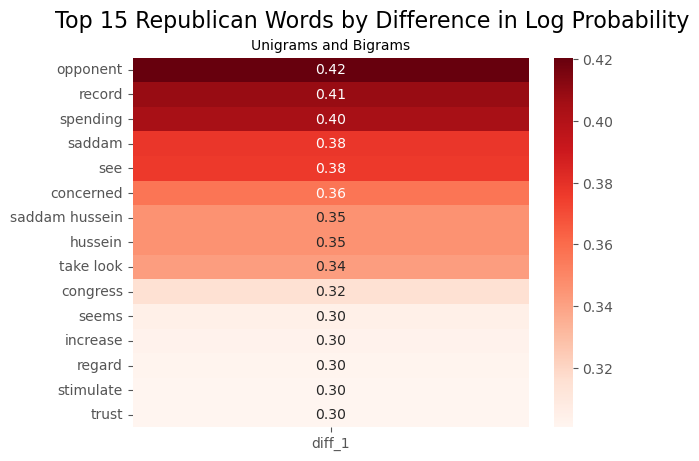

In [285]:
sns.heatmap(heatmap_df_1[-15:].abs().sort_values(by="diff_1", ascending=False), cmap="Reds", annot=True, fmt=".2f")
plt.suptitle("Top 15 Republican Words by Difference in Log Probability", fontsize=16)
plt.title("Unigrams and Bigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")


### 5.c. Unigrams Only

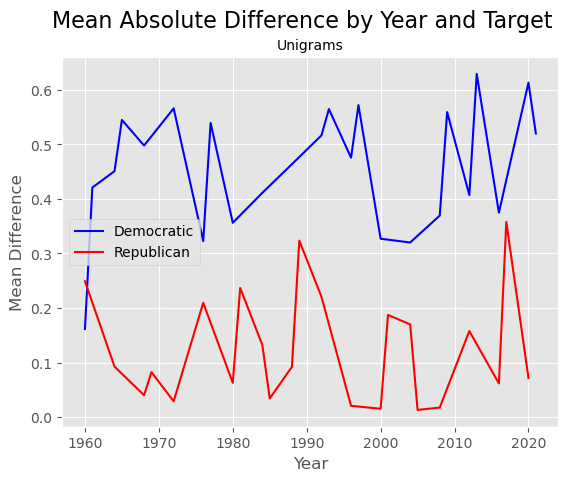

In [288]:
# repeating for just unigrams
X = final_df[["list_tokens"]]
y = final_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tfidf_vectorizer_unigrams = TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 1), smooth_idf=True)
X_train_tfidf_unigrams = tfidf_vectorizer_unigrams.fit_transform(X_train["list_tokens"].apply(lambda x: " ".join(x)))
X_test_tfidf_unigrams = tfidf_vectorizer_unigrams.transform(X_test["list_tokens"].apply(lambda x: " ".join(x)))

final_clf_unigrams = MultinomialNB()
final_clf_unigrams.fit(X_train_tfidf_unigrams, y_train)
y_pred_unigrams = final_clf_unigrams.predict(X_test_tfidf_unigrams)

# Fit and transform all of the text data
tfidf_matrix_unigrams = tfidf_vectorizer_unigrams.transform(final_df["list_tokens"].apply(lambda x: " ".join(x)))

# Create a new column "tfidf" in the dataframe with the vectorized data
final_df["tfidf_unigrams"] = tfidf_matrix_unigrams.toarray().tolist()

# Calculate proba
proba = final_clf_unigrams.predict_proba(final_df["tfidf_unigrams"].to_list())
final_df["proba_unigrams"] = proba.tolist()
final_df["proba_unigrams_0"] = final_df["proba_unigrams"].apply(lambda x: x[0])
final_df["proba_unigrams_1"] = final_df["proba_unigrams"].apply(lambda x: x[1])
final_df["difference_unigrams"] = final_df["proba_unigrams_1"] - final_df["proba_unigrams_0"]

# graph
# Group the data by "Target" and calculate the mean of "difference"
final_df["Year"] = final_df["Year"].astype(int)
grouped_data = final_df.groupby(["Year", "Target"])["difference_unigrams"].mean().abs()
grouped_data = grouped_data.reset_index()

# Iterate over each group and plot a line graph
for target, data in grouped_data.groupby("Target"):
    if target == 0:
        plt.plot(data['Year'], data['difference_unigrams'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['Year'], data['difference_unigrams'], label=f"Target {target}", color='red')

# Set the title and labels for the plot
plt.suptitle("Mean Absolute Difference by Year and Target", fontsize=16)
plt.title("Unigrams", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Mean Difference")

# Set custom legend names
legend_names = ["Democratic", "Republican"]  # Replace with your desired legend names
plt.legend(legend_names);


Text(50.72222222222221, 0.5, '')

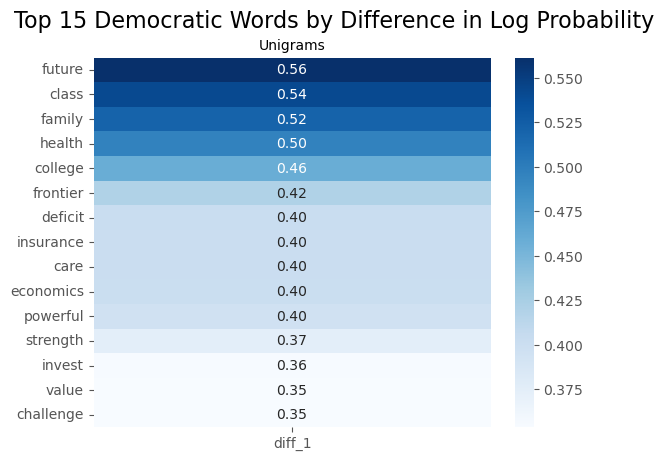

In [292]:
features_unigrams = pd.DataFrame((zip(tfidf_vectorizer_unigrams.get_feature_names_out(), final_clf_unigrams.feature_log_prob_[0], final_clf_unigrams.feature_log_prob_[1])))
features_unigrams["diff_1"] = features_unigrams[2] - features_unigrams[1]

heatmap_df_unigrams = features_unigrams[[0, "diff_1"]].copy()
heatmap_df_unigrams = heatmap_df_unigrams.rename(columns={0: "word"})
heatmap_df_unigrams = heatmap_df_unigrams.sort_values(by="diff_1", ascending=True)
heatmap_df_unigrams = heatmap_df_unigrams.set_index("word")
heatmap_df_unigrams

sns.heatmap(heatmap_df_unigrams[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Democratic Words by Difference in Log Probability", fontsize=16)
plt.title("Unigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

Text(50.72222222222221, 0.5, '')

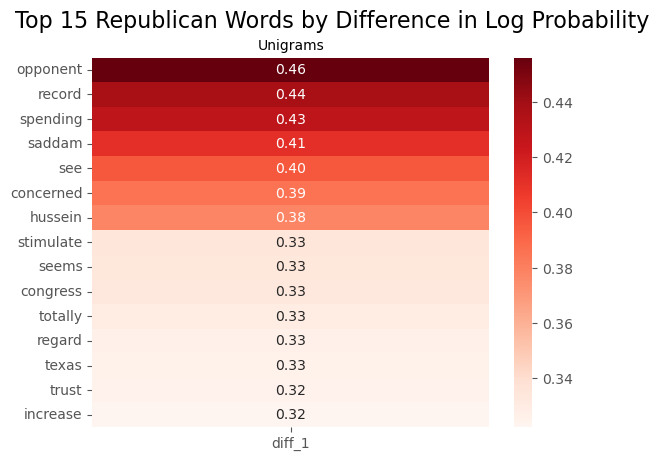

In [293]:
sns.heatmap(heatmap_df_unigrams[-15:].abs().sort_values(by="diff_1", ascending=False), cmap="Reds", annot=True, fmt=".2f")
plt.suptitle("Top 15 Republican Words by Difference in Log Probability", fontsize=16)
plt.title("Unigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

## 6. Next Steps

So what about going forward?

The model is overfit, which means it could use further tuning. One such possible method is Principal Component Analysis. PCA reduces the number of features (and thus the complexity of the model) by creating components consisting of similar features, ones that move in a similar direction. It tries to preserve as much of the variance as possible in those features, so that they describe more of the variance in the target even with a lower dimensional space. Our group did not have the time for this method. 

The model would also benefit from a larger data training set. In particular, it would be helpful to pull in campaign stops and other less formal speech occasions. Including candidates for party nominations who nonetheless failed to become the party nominee would also be worthwhile. It is worth considering bringing in other political rhetoric, not merely from those seeking presidential office, although that may go beyond the scope of this particular dataset and model.

With our trained model, there are other analyses that would be worth pursuing. To name a few: how much does rhetoric change before and after a politician becomes his or her party’s nominee? What about once they win the election? And how much does context affect rhetoric: a town hall, versus cable news, versus a formal press conference, and so on?

Finally, we would want to allow others to make use of this model as they see fit. It could be useful to the public to have a front-facing website that allows individuals to input text and get a likelihood prediciton of the speaker's party affiliation.


## 7. Authors

This project was authored by:
    
Nate Hiatt: natehiatt@gmail.com

[Shelley Wang](https://www.linkedin.com/in/shelleywang22/): ShelleyLWang@gmail.com

[Nathan Bass](https://www.linkedin.com/in/nathan-bass-828794149/)